# Exploratory Data Analysis: User Complaints Dataset

## Contexto
Este notebook forma parte del proyecto de investigación **Construcción de gráfos asistida por LLM**, en donde abordaremos a aprofundidad el dataset de la NHTSA sobre quejas reportadas en vehículos from NHTSA. Este notebook f of a research project on


# Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore')

# Import our custom EDA class
import sys
sys.path.append('../src')
from eda_analysis import ComplaintsEDA

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moral\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moral\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Carga y limpieza de datos

### 1. Eliminación de Registros con Año Inválido (YEAR=9999)
- **Eliminado**: 1,137 filas con YEAR=9999
- **Razón**: Estos registros incluyen:
  - Fallas en llantas donde fabricante/modelo se refieren a las llantas
  - Accesorios (sillas para bebés, cargadores portátiles)
  - Productos desconocidos sin identificación adecuada
- **Resultado**: Enfoque solo en quejas reales de vehículos

### 2. Eliminación de Columnas Relacionadas con Asientos
- **Columnas eliminadas**: `SEAT_TYPE`, `RESTRAINT_TYPE`, `MANUF_DATE`
- **Razón**: Relacionadas con accesorios de asientos, no con quejas de vehículos
- **Impacto**: Conjunto de datos más limpio y enfocado en problemas específicos del vehículo

### 3. Eliminación de Columnas Relacionadas con Dealers
- **Columnas eliminadas**: `DEALER_TEL`, `DEALER_ZIP`
- **Razón**: No relevantes para el análisis de quejas
- **Impacto**: Menos ruido en el conjunto de datos

### 4. Filtrado por Tipo de Producto
- **Eliminado**: 12 filas con `PROD_TYPE='E'` o vacío
- **Razón**: Corresponden a accesorios en tránsito
- **Acción**: Se eliminó la columna `PROD_TYPE` completamente después del filtrado

### 5. Eliminación de Columnas Escasas
- **Eliminado**: `FUEL_TYPE` (solo 5 registros)
- **Razón**: Datos insuficientes para un análisis significativo

### 6. Eliminación de Columnas Vacías
- **Eliminado**: `LOC_OF_TIRE`, `DOT`, `DRIVE_TRAIN` (vacías después del filtrado)
- **Conservado**: `PURCH_DATE` (tiene 2 valores no nulos)

### Resumen
- **Conjunto de datos original**: 79,376 filas × 49 columnas
- **Después de la limpieza**: 78,227 filas × 39 columnas  
- **Después del filtro 2025**: 59,548 filas × 30 columnas
- **Reducción de datos**: 1.45% de filas, 20.41% de columnas eliminadas
- **Enfoque final**: Quejas específicas de vehículos del 2025 únicamente



In [2]:
# Iniciar EDA con limpieza de pipeline
eda = ComplaintsEDA("../data/CMPLT_2025.csv")

# Cargamos nuestros datos limpiando nuestros datos, filtrando por datos recopilados en el año 2025
print("Cargar pipeline de limpieza...")
eda.load_data(filter_year=2025)

# Obtener dataset
df = eda.df

print(f"\nFigura del dataset: {df.shape}")
print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Columnas restantes: {len(df.columns)}")


Cargar pipeline de limpieza...
Loading data...
Aplicando transformacion de datos y limpieza...
  Converted YEAR to numeric
  Converted INJURED to numeric
  Converted DEATHS to numeric
  Converted MILES to numeric
  Converted OCCURENCES to numeric
  Converted VEHSPEED to numeric
  Converted NUMCYLS to numeric
  Converted FAILDATE to datetime
  Converted DATEA to datetime
  Converted LDATE to datetime
  Converted MANUFDATE to datetime
  Normalized text in MFRNAME
  Normalized text in MAKE
  Normalized text in MODEL
  Normalized text in COMPONENT
  Normalized text in CITY
  Normalized text in STATE
  Normalized text in DEALERCITY
  Normalized text in DEALERNAME

APPLYING DATA CLEANING PIPELINE
Original dataset shape: (79376, 49)

1. Removing 1137 rows with YEAR=9999 (tire failures, accessories, unknown products)
   Remaining rows: 78239

2. Removing seat-related columns: ['SEATTYPE', 'RESTRAINTTYPE', 'MANUFDATE']

3. Removing dealer-related columns: ['DEALERTEL', 'DEALERZIP']

4. Removing

In [3]:
# Mostrar información limpia del dataset
print("Cleaned dataset columns:")
print(df.columns.tolist())

print(f"\nDataset info:")
print(f"Shape: {df.shape}")
print(f"Data types:")
print(df.dtypes.value_counts())

# Mostrar rango de fechas en el dataset actual
if 'FAILDATE' in df.columns and len(df) > 0:
    print(f"Date range for 2025: {df['FAILDATE'].min().strftime('%Y-%m-%d')} to {df['FAILDATE'].max().strftime('%Y-%m-%d')}")

# Las columnas vacias ya se eliminaron por medio de nuestra clase ComplaintsEDA
print("Empty columns have already been removed by the cleaning pipeline.")


Cleaned dataset columns:
['CMPLID', 'ODINO', 'MFRNAME', 'MAKE', 'MODEL', 'YEAR', 'CRASH', 'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPONENT', 'CITY', 'STATE', 'VIN', 'DATEA', 'LDATE', 'MILES', 'CMPLDESCR', 'CMPLTYPE', 'POLICERPT', 'ORIGINALOWNER', 'ANTIBRAKES', 'CRUISECONT', 'VEHSPEED', 'DEALERNAME', 'DEALERCITY', 'DEALERSTATE', 'MEDICALATTN', 'VEHICLESTOWED']

Dataset info:
Shape: (59548, 30)
Data types:
object            20
int64              5
datetime64[ns]     3
float64            2
Name: count, dtype: int64
Date range for 2025: 2025-01-01 to 2025-09-18
Empty columns have already been removed by the cleaning pipeline.


In [4]:
df.head()

,CMPLID,ODINO,MFRNAME,MAKE,MODEL,YEAR,CRASH,FAILDATE,FIRE,INJURED,DEATHS,COMPONENT,CITY,STATE,VIN,DATEA,LDATE,MILES,CMPLDESCR,CMPLTYPE,POLICERPT,ORIGINALOWNER,ANTIBRAKES,CRUISECONT,VEHSPEED,DEALERNAME,DEALERCITY,DEALERSTATE,MEDICALATTN,VEHICLESTOWED
39,2051922,11633499,"CHRYSLER (FCA US, LLC)",RAM,1500,2015,N,2025-01-01,N,0,0,ELECTRICAL SYSTEM,HAMMOND,IN,1C6RR7LG8FS,2025-01-01,2025-01-01,NaN,Truck loses power when you accelerate at any v...,IVOQ,N,N,N,N,35.0,<NA>,<NA>,NaN,N,N
40,2051923,11633499,"CHRYSLER (FCA US, LLC)",RAM,1500,2015,N,2025-01-01,N,0,0,STEERING,HAMMOND,IN,1C6RR7LG8FS,2025-01-01,2025-01-01,NaN,Truck loses power when you accelerate at any v...,IVOQ,N,N,N,N,35.0,<NA>,<NA>,NaN,N,N
48,2051931,11633505,FORD MOTOR COMPANY,FORD,FUSION,2012,N,2025-01-01,N,0,0,ENGINE,BUFORD,GA,3FAHP0HA5CR,2025-01-01,2025-01-01,NaN,"Vehicle loses power while driving, with no res...",IVOQ,N,N,N,N,40.0,<NA>,<NA>,NaN,N,N
49,2051932,11633505,FORD MOTOR COMPANY,FORD,FUSION,2012,N,2025-01-01,N,0,0,FUEL/PROPULSION SYSTEM,BUFORD,GA,3FAHP0HA5CR,2025-01-01,2025-01-01,NaN,"Vehicle loses power while driving, with no res...",IVOQ,N,N,N,N,40.0,<NA>,<NA>,NaN,N,N
70,2051953,11633518,HYUNDAI MOTOR AMERICA,HYUNDAI,TUCSON,2017,N,2025-01-01,N,0,0,POWER TRAIN,EBENSBURG,PA,KM8J3CA23HU,2025-01-01,2025-01-01,NaN,There is an intermittent problem with the tran...,IVOQ,N,N,N,N,NaN,<NA>,<NA>,NaN,N,N


In [5]:
# Las transformaciones de datos ya han sido aplicadas por la clase EDA
print("Las transformaciones de datos ya han sido aplicadas por el pipeline de limpieza.")
print("Esto incluye:")
print("  - Conversión numérica para las columnas correspondientes")
print("  - Conversión de formato de fechas")
print("  - Normalización de texto (strip, mayúsculas)")
print("  - Eliminación de valores inválidos YEAR=9999")
print("  - Pipeline completo de limpieza de datos")


Las transformaciones de datos ya han sido aplicadas por el pipeline de limpieza.
Esto incluye:
  - Conversión numérica para las columnas correspondientes
  - Conversión de formato de fechas
  - Normalización de texto (strip, mayúsculas)
  - Eliminación de valores inválidos YEAR=9999
  - Pipeline completo de limpieza de datos


# Identificación de variables

In [6]:
print("\n=== Tipos de datos después del pipeline de depuración ===")
print(df.dtypes.value_counts())

print("\n=== Variables numéricas detectadas ===")
print(df.select_dtypes(include=['number']).columns.tolist())

print("\n=== Variables categóricas detectadas ===")
print(df.select_dtypes(include=['object', 'category']).columns.tolist())


=== Tipos de datos después del pipeline de depuración ===
object            20
int64              5
datetime64[ns]     3
float64            2
Name: count, dtype: int64

=== Variables numéricas detectadas ===
['CMPLID', 'ODINO', 'YEAR', 'INJURED', 'DEATHS', 'MILES', 'VEHSPEED']

=== Variables categóricas detectadas ===
['MFRNAME', 'MAKE', 'MODEL', 'CRASH', 'FIRE', 'COMPONENT', 'CITY', 'STATE', 'VIN', 'CMPLDESCR', 'CMPLTYPE', 'POLICERPT', 'ORIGINALOWNER', 'ANTIBRAKES', 'CRUISECONT', 'DEALERNAME', 'DEALERCITY', 'DEALERSTATE', 'MEDICALATTN', 'VEHICLESTOWED']


In [7]:
df.dtypes


CMPLID                    int64
ODINO                     int64
MFRNAME                  object
MAKE                     object
MODEL                    object
YEAR                      int64
CRASH                    object
FAILDATE         datetime64[ns]
FIRE                     object
INJURED                   int64
DEATHS                    int64
COMPONENT                object
CITY                     object
STATE                    object
VIN                      object
DATEA            datetime64[ns]
LDATE            datetime64[ns]
MILES                   float64
CMPLDESCR                object
CMPLTYPE                 object
POLICERPT                object
ORIGINALOWNER            object
ANTIBRAKES               object
CRUISECONT               object
VEHSPEED                float64
DEALERNAME               object
DEALERCITY               object
DEALERSTATE              object
MEDICALATTN              object
VEHICLESTOWED            object
dtype: object

In [8]:
df.describe()

,CMPLID,ODINO,YEAR,FAILDATE,INJURED,DEATHS,DATEA,LDATE,MILES,VEHSPEED
count,5.954800e+04,5.954800e+04,59548.000000,59548,59548.000000,59548.000000,59548,59548,9408.000000,29747.000000
mean,2.094752e+06,1.166316e+07,2019.106469,2025-05-03 00:27:41.315241216,0.030580,0.001226,2025-05-24 08:24:07.544837888,2025-05-24 08:24:07.544837888,86651.384673,34.995966
min,2.051922e+06,1.163350e+07,1986.000000,2025-01-01 00:00:00,0.000000,0.000000,2025-01-01 00:00:00,2025-01-01 00:00:00,0.000000,0.000000
25%,2.076528e+06,1.165046e+07,2017.000000,2025-03-01 00:00:00,0.000000,0.000000,2025-03-25 00:00:00,2025-03-25 00:00:00,45000.000000,5.000000
50%,2.095688e+06,1.166388e+07,2020.000000,2025-05-02 00:00:00,0.000000,0.000000,2025-05-30 00:00:00,2025-05-30 00:00:00,81000.000000,35.000000
75%,2.113684e+06,1.167634e+07,2022.000000,2025-07-04 00:00:00,0.000000,0.000000,2025-07-26 00:00:00,2025-07-26 00:00:00,120000.000000,60.000000
max,2.131258e+06,1.168826e+07,2026.000000,2025-09-18 00:00:00,10.000000,15.000000,2025-09-18 00:00:00,2025-09-18 00:00:00,763309.000000,999.000000
std,2.195309e+04,1.520873e+04,4.259369,NaN,0.245171,0.110030,NaN,NaN,59157.986073,32.301967


# Valores faltantes

¿Qué valores faltantes se encuentran en el dataset? ¿Se pueden identificar patrones?


Resumen de Valores Faltantes:
          Columna  Conteo_Faltantes  Porcentaje_Faltantes
27    DEALERSTATE             54269             91.134883
26     DEALERCITY             54251             91.104655
25     DEALERNAME             53620             90.045006
17          MILES             50140             84.200981
24       VEHSPEED             29801             50.045342
14            VIN               399              0.670048
29  VEHICLESTOWED                17              0.028548
23     CRUISECONT                17              0.028548
22     ANTIBRAKES                17              0.028548
21  ORIGINALOWNER                17              0.028548
18      CMPLDESCR                12              0.020152
12           CITY                 8              0.013435


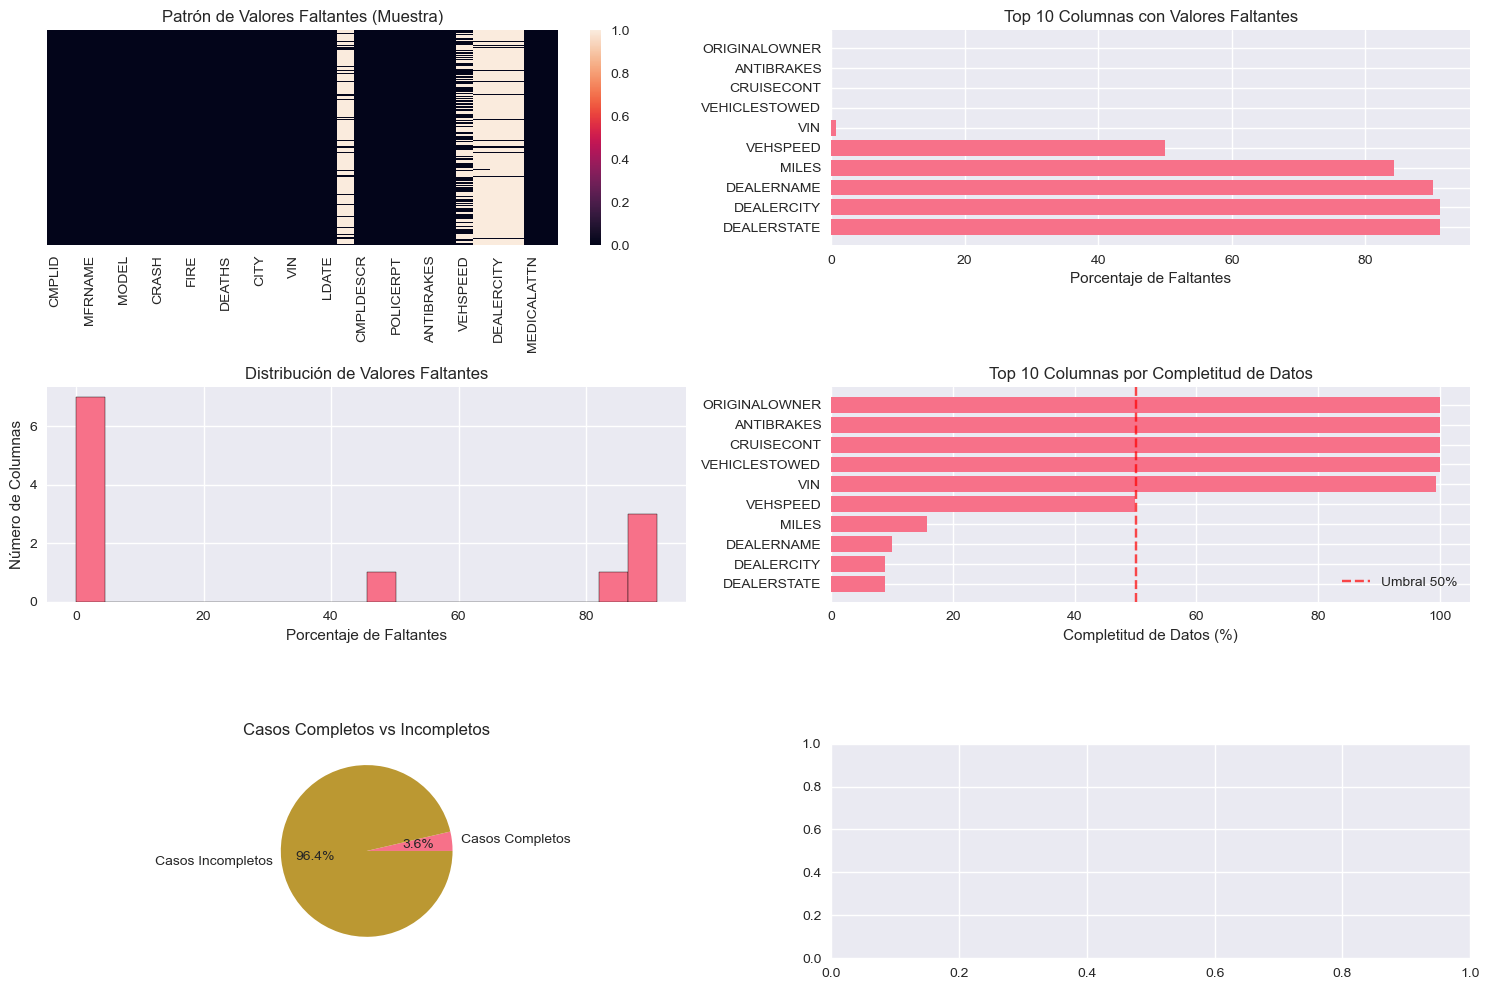


Casos completos (sin valores faltantes en NINGUNA columna): 2160 (3.63%)
Columnas sin valores faltantes: 18
Columnas con todos los valores faltantes: 0

Resumen de Completitud de Datos:
  Alta completitud (≥80%): 25 columnas
  Completitud media (50-79%): 0 columnas
  Baja completitud (<50%): 5 columnas


In [9]:
# Análisis de valores faltantes
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Columna': missing_data.index,
    'Conteo_Faltantes': missing_data.values,
    'Porcentaje_Faltantes': missing_percentage.values
}).sort_values('Porcentaje_Faltantes', ascending=False)

print("Resumen de Valores Faltantes:")
print(missing_df[missing_df['Conteo_Faltantes'] > 0])

# Visualizar patrones en valores faltantes
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Mapa de calor de valores faltantes
missing_sample = df.sample(min(1000, len(df))).isnull()
sns.heatmap(missing_sample, cbar=True, yticklabels=False, ax=axes[0,0])
axes[0,0].set_title('Patrón de Valores Faltantes (Muestra)')

# Gráfico de barras de valores faltantes
top_missing = missing_df.head(10)
axes[0,1].barh(range(len(top_missing)), top_missing['Porcentaje_Faltantes'])
axes[0,1].set_yticks(range(len(top_missing)))
axes[0,1].set_yticklabels(top_missing['Columna'])
axes[0,1].set_xlabel('Porcentaje de Faltantes')
axes[0,1].set_title('Top 10 Columnas con Valores Faltantes')

# Distribución de valores faltantes
axes[1,0].hist(missing_percentage[missing_percentage > 0], bins=20, edgecolor='black')
axes[1,0].set_xlabel('Porcentaje de Faltantes')
axes[1,0].set_ylabel('Número de Columnas')
axes[1,0].set_title('Distribución de Valores Faltantes')

# Completitud de datos por columna
missing_by_col = df.isnull().sum().sort_values(ascending=False)
completeness_by_col = (1 - missing_by_col / len(df)) * 100
top_10_missing = completeness_by_col.head(10)

axes[1,1].barh(range(len(top_10_missing)), top_10_missing.values)
axes[1,1].set_yticks(range(len(top_10_missing)))
axes[1,1].set_yticklabels(top_10_missing.index)
axes[1,1].set_xlabel('Completitud de Datos (%)')
axes[1,1].set_title('Top 10 Columnas por Completitud de Datos')
axes[1,1].axvline(x=50, color='red', linestyle='--', alpha=0.7, label='Umbral 50%')
axes[1,1].legend()

# Análisis de casos completos
complete_cases = df.dropna()
axes[2,0].pie([len(complete_cases), len(df) - len(complete_cases)], 
labels=['Casos Completos', 'Casos Incompletos'],
autopct='%1.1f%%')
axes[2,0].set_title('Casos Completos vs Incompletos')

plt.tight_layout()
plt.show()

# Resumen más informativo de datos faltantes
complete_cases = df.dropna()
print(f"\nCasos completos (sin valores faltantes en NINGUNA columna): {len(complete_cases)} ({len(complete_cases)/len(df)*100:.2f}%)")
print(f"Columnas sin valores faltantes: {sum(missing_data == 0)}")
print(f"Columnas con todos los valores faltantes: {sum(missing_data == len(df))}")

# Mostrar columnas con distintos niveles de completitud
alta_completitud = completeness_by_col[completeness_by_col >= 80]
media_completitud = completeness_by_col[(completeness_by_col >= 50) & (completeness_by_col < 80)]
baja_completitud = completeness_by_col[completeness_by_col < 50]

print(f"\nResumen de Completitud de Datos:")
print(f"  Alta completitud (≥80%): {len(alta_completitud)} columnas")
print(f"  Completitud media (50-79%): {len(media_completitud)} columnas") 
print(f"  Baja completitud (<50%): {len(baja_completitud)} columnas")



## Análisis de variables numéricas

¿Cuál es el resumen estadístico del dataset?


In [10]:
# Tipos de datos e información básica
print("Información del Dataset:")
print(f"Forma: {df.shape}")
print(f"Uso de memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Tipos de datos:")
print(df.dtypes.value_counts())

# Estadísticas resumidas para columnas numéricas (excluyendo identificadores)
numeric_cols = df.select_dtypes(include=[np.number]).columns
# Eliminar columnas identificadoras del análisis
identifier_cols = ['CMPLID', 'ODINO']  # Ambas son identificadores, no variables analíticas
for col in identifier_cols:
    if col in numeric_cols:
        numeric_cols = numeric_cols.drop(col)

print(f"\nColumnas numéricas ({len(numeric_cols)}):")
print(numeric_cols.tolist())

if len(numeric_cols) > 0:
    print("\nEstadísticas Resumidas Numéricas:")
    print(df[numeric_cols].describe())
    
    # Estadísticas adicionales
    print("\nEstadísticas Adicionales:")
    numeric_stats = pd.DataFrame({
        'Asimetría': df[numeric_cols].skew(),
        'Curtosis': df[numeric_cols].kurtosis(),
        'Varianza': df[numeric_cols].var(),
        'Coef_Variación': df[numeric_cols].std() / df[numeric_cols].mean()
    })
    print(numeric_stats)


Información del Dataset:
Forma: (59548, 30)
Uso de memoria: 102.43 MB
Tipos de datos:
object            20
int64              5
datetime64[ns]     3
float64            2
Name: count, dtype: int64

Columnas numéricas (5):
['YEAR', 'INJURED', 'DEATHS', 'MILES', 'VEHSPEED']

Estadísticas Resumidas Numéricas:
               YEAR       INJURED        DEATHS          MILES      VEHSPEED
count  59548.000000  59548.000000  59548.000000    9408.000000  29747.000000
mean    2019.106469      0.030580      0.001226   86651.384673     34.995966
std        4.259369      0.245171      0.110030   59157.986073     32.301967
min     1986.000000      0.000000      0.000000       0.000000      0.000000
25%     2017.000000      0.000000      0.000000   45000.000000      5.000000
50%     2020.000000      0.000000      0.000000   81000.000000     35.000000
75%     2022.000000      0.000000      0.000000  120000.000000     60.000000
max     2026.000000     10.000000     15.000000  763309.000000    999.000000


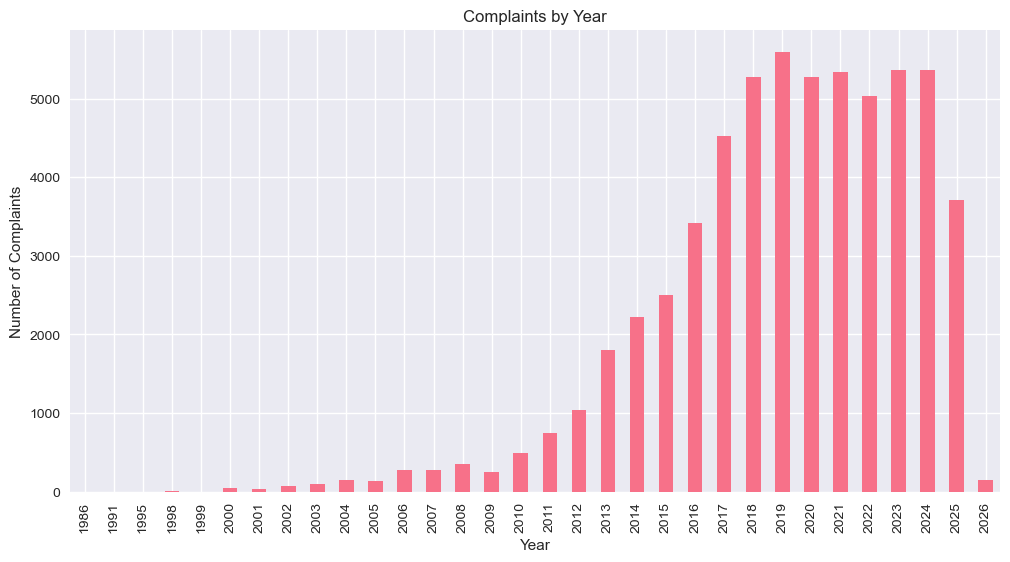

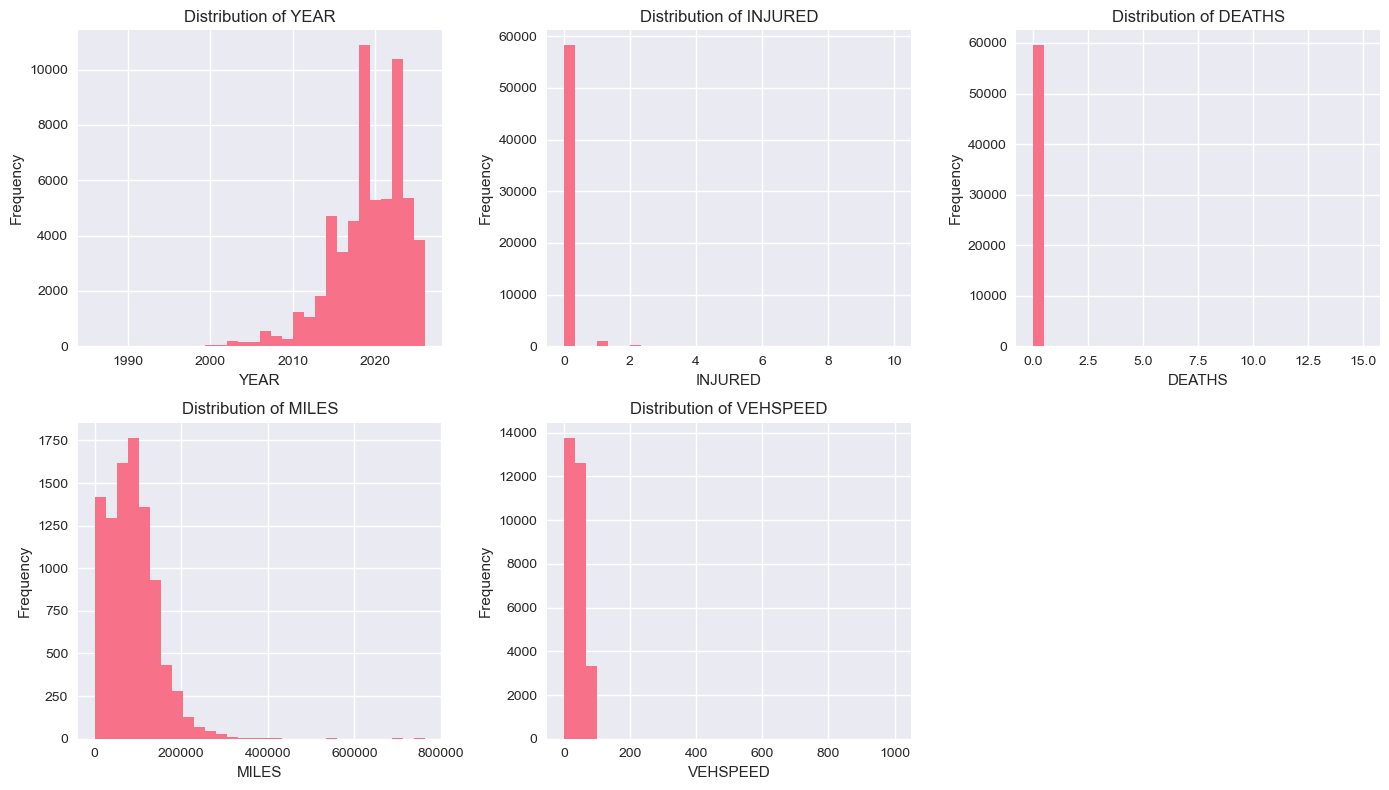

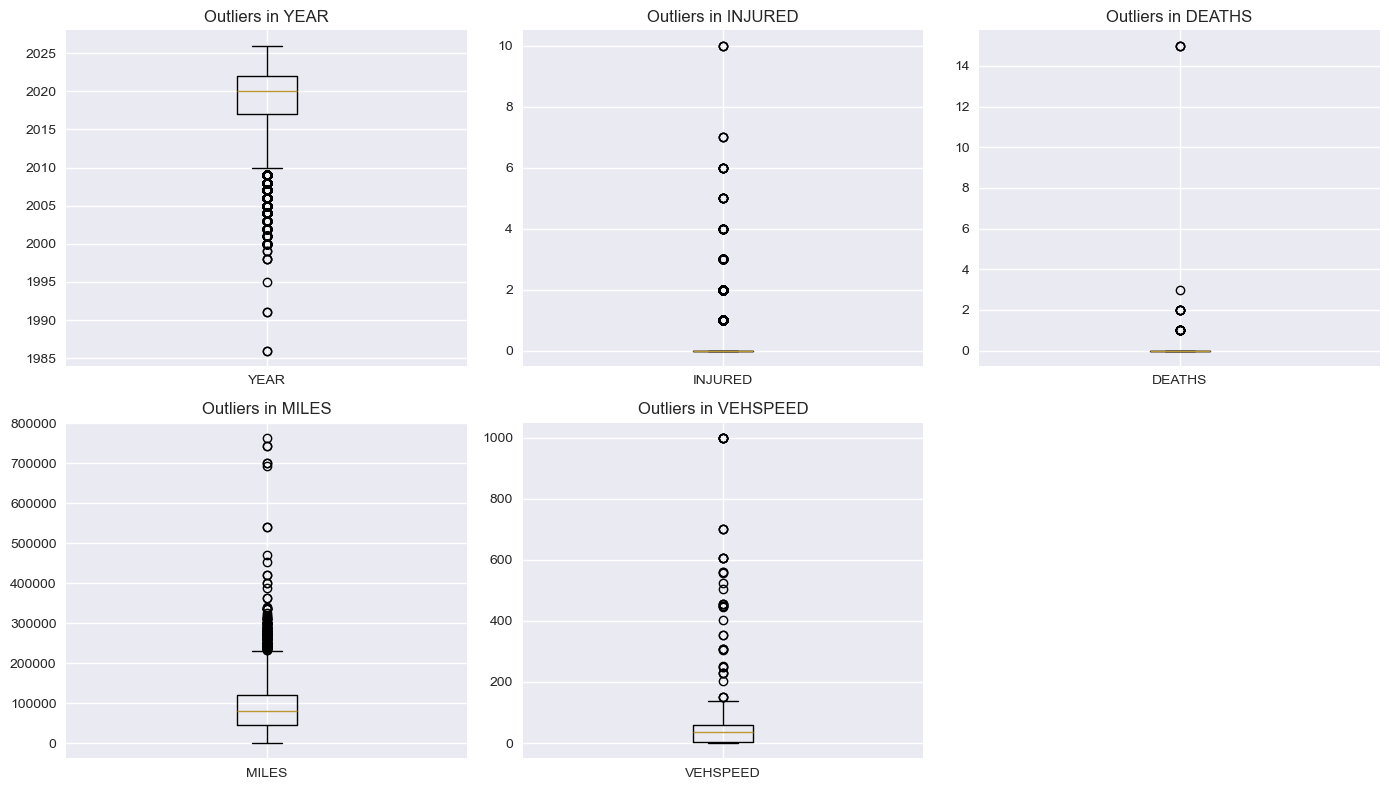

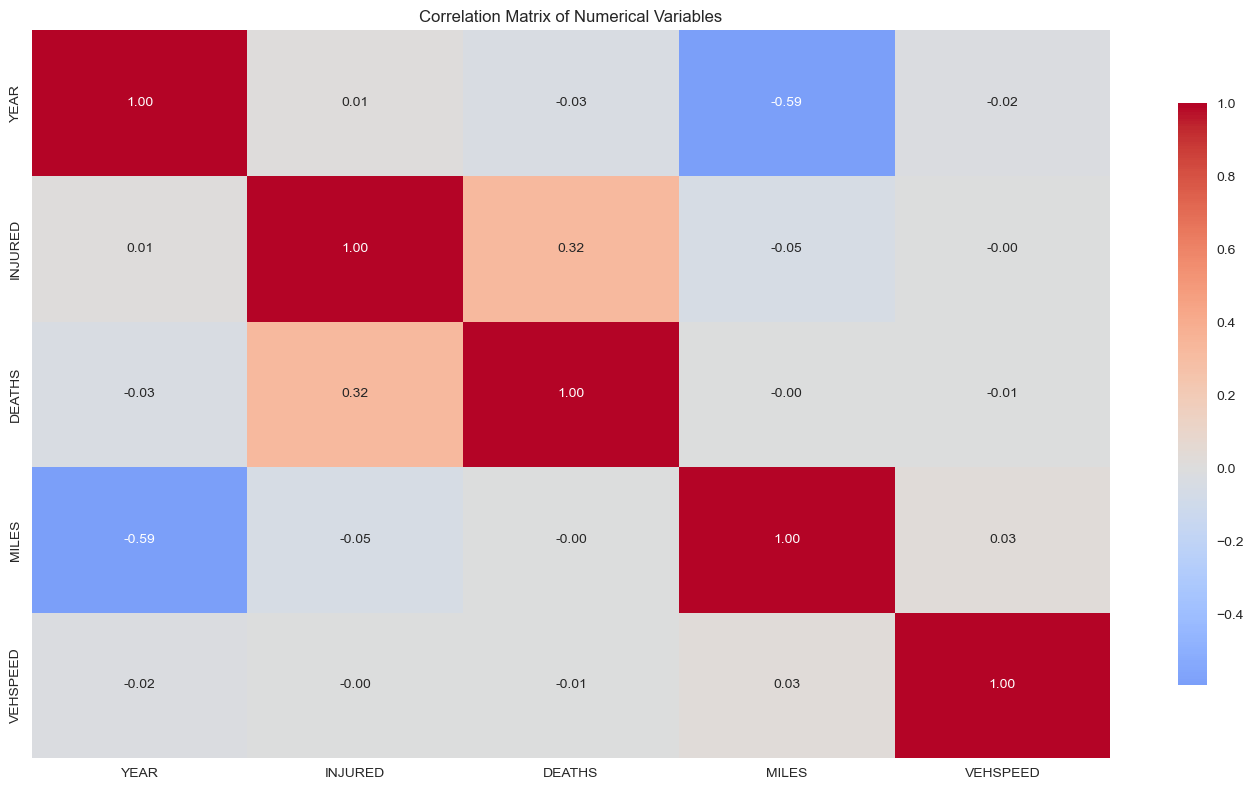

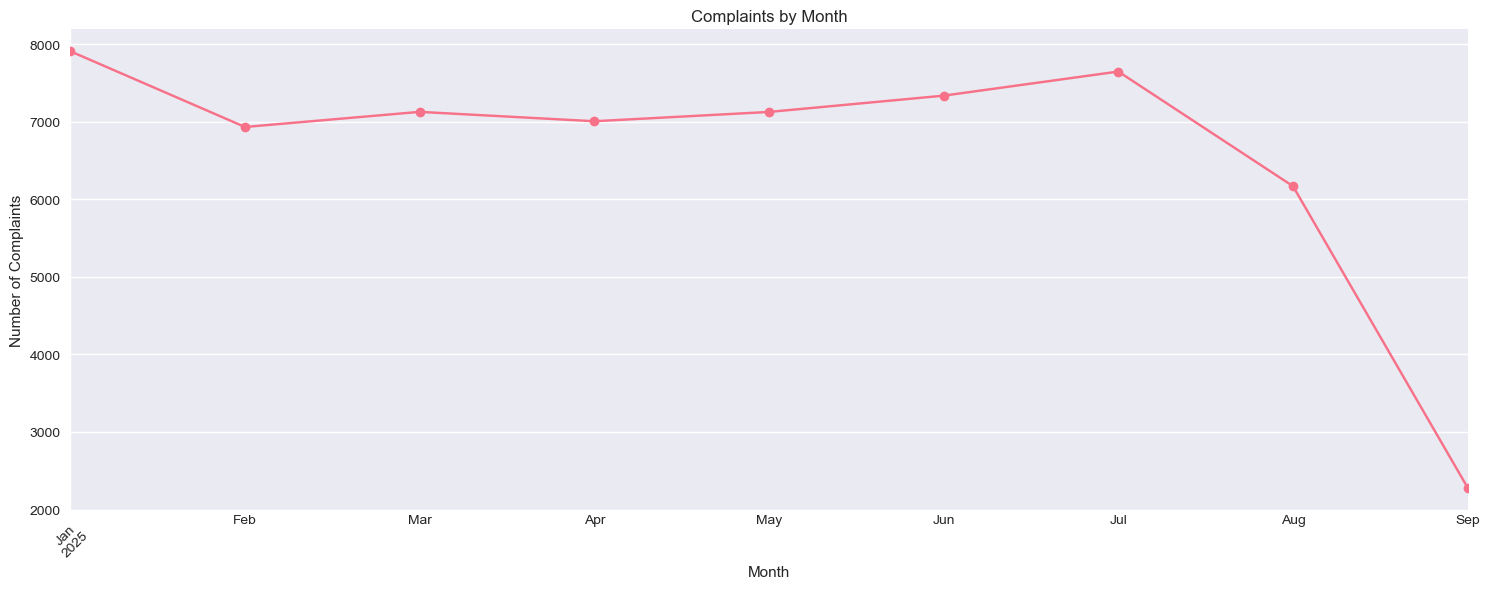

In [11]:

# 1) Complaints by Year
if "YEAR" in df.columns:
    by_year = df["YEAR"].dropna().astype(int).value_counts().sort_index()
    plt.figure(figsize=(12,6))
    by_year.plot(kind="bar")
    plt.title("Complaints by Year")
    plt.xlabel("Year"); plt.ylabel("Number of Complaints")
    plt.show()

# 2) Distribuciones (hist) de numéricas
prefer_order = ["YEAR","INJURED","DEATHS","MILES","VEHSPEED"]
ordered = [c for c in prefer_order if c in numeric_cols]
rest = [c for c in numeric_cols if c not in ordered]
plot_cols = ordered + rest

n = len(plot_cols)
if n:
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(14, 4*nrows))
    for i, col in enumerate(plot_cols, 1):
        plt.subplot(nrows, ncols, i)
        # hist robusto
        vals = pd.to_numeric(df[col], errors="coerce").dropna()
        plt.hist(vals, bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 4) Boxplots para outliers (subset útil)
focus = [c for c in ["YEAR","INJURED","DEATHS","MILES","VEHSPEED"] if c in numeric_cols]
if focus:
    n = len(focus)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(14, 4*nrows))
    for i, col in enumerate(focus, 1):
        plt.subplot(nrows, ncols, i)
        vals = pd.to_numeric(df[col], errors="coerce")
        plt.boxplot(vals.dropna(), vert=True, labels=[col], showfliers=True)
        plt.title(f"Outliers in {col}")
    plt.tight_layout()
    plt.show()

# 5) Correlation heatmap (solo numéricas)
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(numeric_only=True)
    plt.figure(figsize=(14,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                square=False, cbar_kws={'shrink':0.8})
    plt.title("Correlation Matrix of Numerical Variables")
    plt.tight_layout()
    plt.show()

# 6) Tendencias en este año

df_temp = df.copy()
df_temp['FAILDATE'] = pd.to_datetime(df_temp['FAILDATE'], format='%Y%m%d', errors='coerce')

valid_dates = df_temp.dropna(subset=['FAILDATE'])
        
if len(valid_dates) > 0:
            # Monthly trends
            monthly_counts = valid_dates.groupby(valid_dates['FAILDATE'].dt.to_period('M')).size()
            
            plt.figure(figsize=(15, 6))
            monthly_counts.plot(kind='line', marker='o')
            plt.title('Complaints by Month')
            plt.xlabel('Month')
            plt.ylabel('Number of Complaints')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

## Análisis de variables categóricas

¿Cuál es el comportamiento de las variables descriptivas? ¿Se pueden incluir en nuestro análisis de correlación relaciando por medio de alguna codificación numérica? (Por ejemplo: One Hot Encoding)


In [12]:
def get_categorical_columns(df):
    # object o category
    return df.select_dtypes(include=['object', 'category']).columns.tolist()

def summarize_categoricals(df, save_csv_path=None):
    cat_cols = get_categorical_columns(df)
    if not cat_cols:
        print("No hay variables categóricas en el DataFrame.")
        return None

    rows = []
    for c in cat_cols:
        n = len(df)
        nunique = df[c].nunique(dropna=True)
        missing = df[c].isna().sum()
        missing_pct = 100.0 * missing / n
        top_vals = df[c].value_counts(dropna=False).head(5)
        rows.append({
            "column": c,
            "dtype": str(df[c].dtype),
            "n_unique": nunique,
            "missing": missing,
            "missing_pct": round(missing_pct, 2),
            "top_values_preview": "; ".join([f"{k}:{v}" for k,v in top_vals.items()])
        })

    summary = pd.DataFrame(rows).sort_values(["n_unique","missing_pct","column"])
    print("\n=== Resumen de variables categóricas ===")
    print(summary[["column","dtype","n_unique","missing","missing_pct"]])

    if save_csv_path:
        summary.to_csv(save_csv_path, index=False)
        print(f"Resumen guardado en: {save_csv_path}")
    return summary

cat_summary = summarize_categoricals(df)


=== Resumen de variables categóricas ===
           column   dtype  n_unique  missing  missing_pct
10       CMPLTYPE  object         2        0         0.00
3           CRASH  object         2        0         0.00
4            FIRE  object         2        0         0.00
18    MEDICALATTN  object         2        0         0.00
11      POLICERPT  object         2        0         0.00
13     ANTIBRAKES  object         2       17         0.03
14     CRUISECONT  object         2       17         0.03
12  ORIGINALOWNER  object         2       17         0.03
19  VEHICLESTOWED  object         2       17         0.03
17    DEALERSTATE  object        53    54269        91.13
7           STATE  object        58        0         0.00
0         MFRNAME  object       117        0         0.00
1            MAKE  object       147        0         0.00
5       COMPONENT  object       344        0         0.00
2           MODEL  object      1106        0         0.00
16     DEALERCITY  object     

In [13]:
# Estadísticas resumidas para columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nColumnas categóricas ({len(categorical_cols)}):")
print(categorical_cols.tolist())

if len(categorical_cols) > 0:
    print("\nResumen Categórico:")
    for col in categorical_cols[:10]:  # Mostrar primeras 10 columnas categóricas
        print(f"\n{col}:")
        print(f"  Valores únicos: {df[col].nunique()}")
        print(f"  Más frecuente: {df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A'}")
        print(f"  Top 5 valores:")
        print(df[col].value_counts().head())


Columnas categóricas (20):
['MFRNAME', 'MAKE', 'MODEL', 'CRASH', 'FIRE', 'COMPONENT', 'CITY', 'STATE', 'VIN', 'CMPLDESCR', 'CMPLTYPE', 'POLICERPT', 'ORIGINALOWNER', 'ANTIBRAKES', 'CRUISECONT', 'DEALERNAME', 'DEALERCITY', 'DEALERSTATE', 'MEDICALATTN', 'VEHICLESTOWED']

Resumen Categórico:

MFRNAME:
  Valores únicos: 117
  Más frecuente: FORD MOTOR COMPANY
  Top 5 valores:
MFRNAME
FORD MOTOR COMPANY                  11953
GENERAL MOTORS, LLC                  9925
CHRYSLER (FCA US, LLC)               7609
HONDA (AMERICAN HONDA MOTOR CO.)     6753
HYUNDAI MOTOR AMERICA                3791
Name: count, dtype: int64

MAKE:
  Valores únicos: 147
  Más frecuente: FORD
  Top 5 valores:
MAKE
FORD         11410
HONDA         5989
CHEVROLET     5571
HYUNDAI       3647
JEEP          3626
Name: count, dtype: int64

MODEL:
  Valores únicos: 1106
  Más frecuente: F-150
  Top 5 valores:
MODEL
F-150             2444
ESCAPE            2001
1500              1609
SILVERADO 1500    1485
EXPLORER          

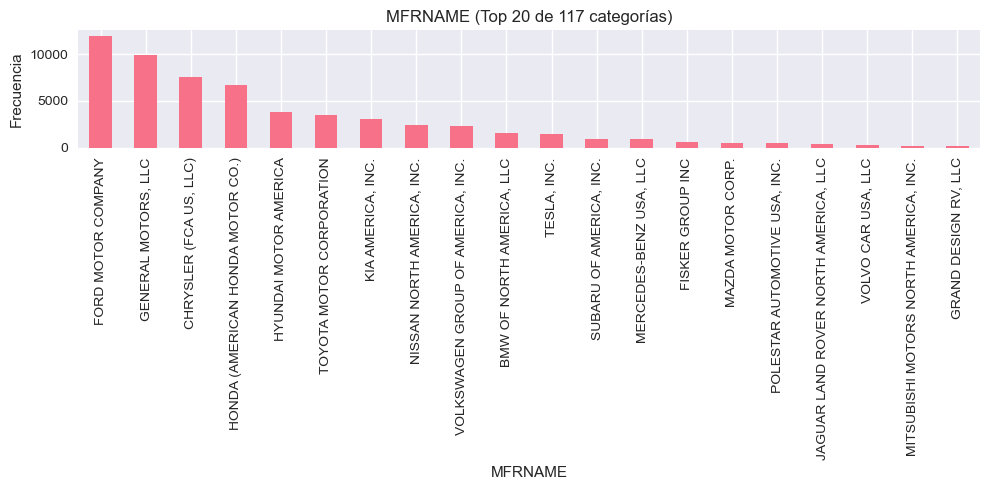

Guardado: results/figures/categorical/MFRNAME_distribution.png


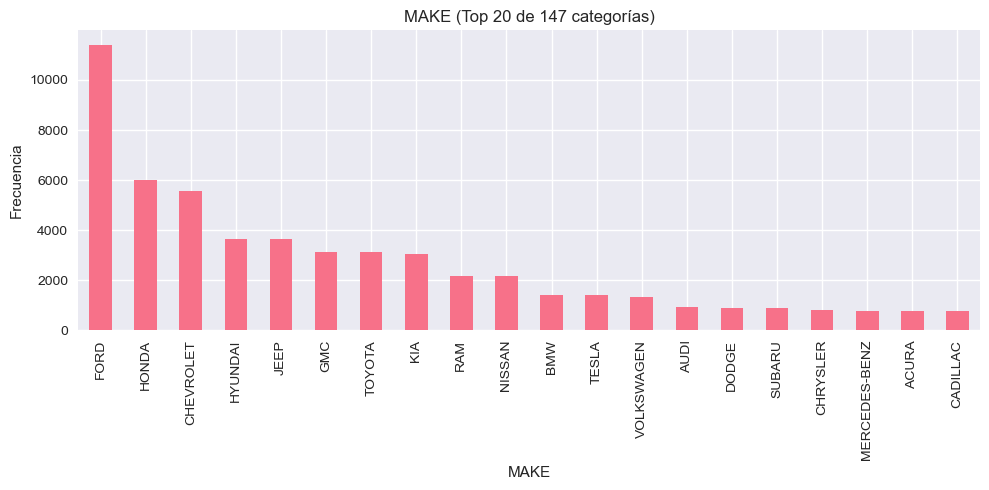

Guardado: results/figures/categorical/MAKE_distribution.png
[skip] MODEL: alta cardinalidad (1106). Solo resumido.


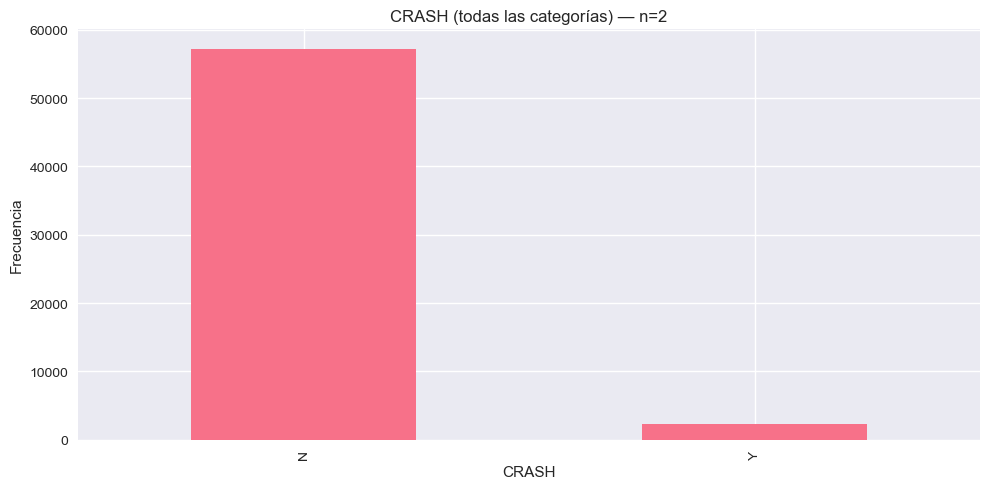

Guardado: results/figures/categorical/CRASH_distribution.png


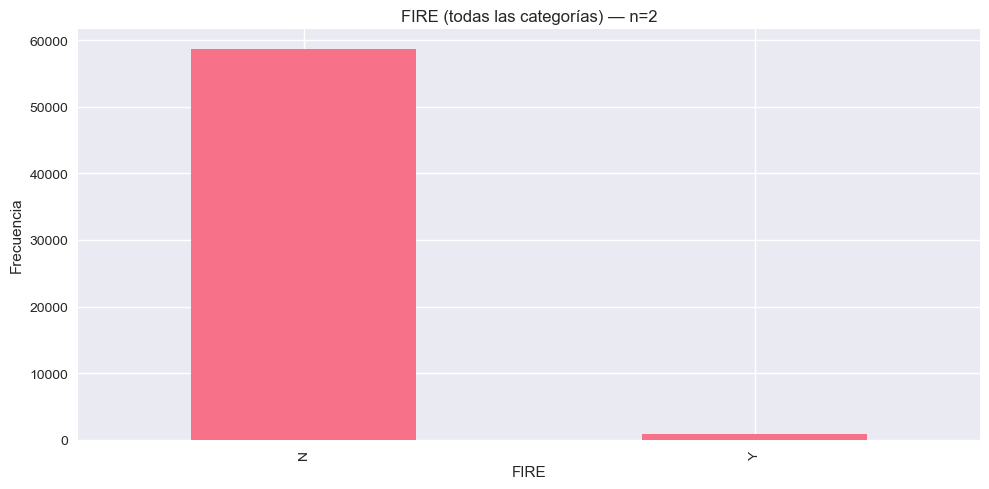

Guardado: results/figures/categorical/FIRE_distribution.png


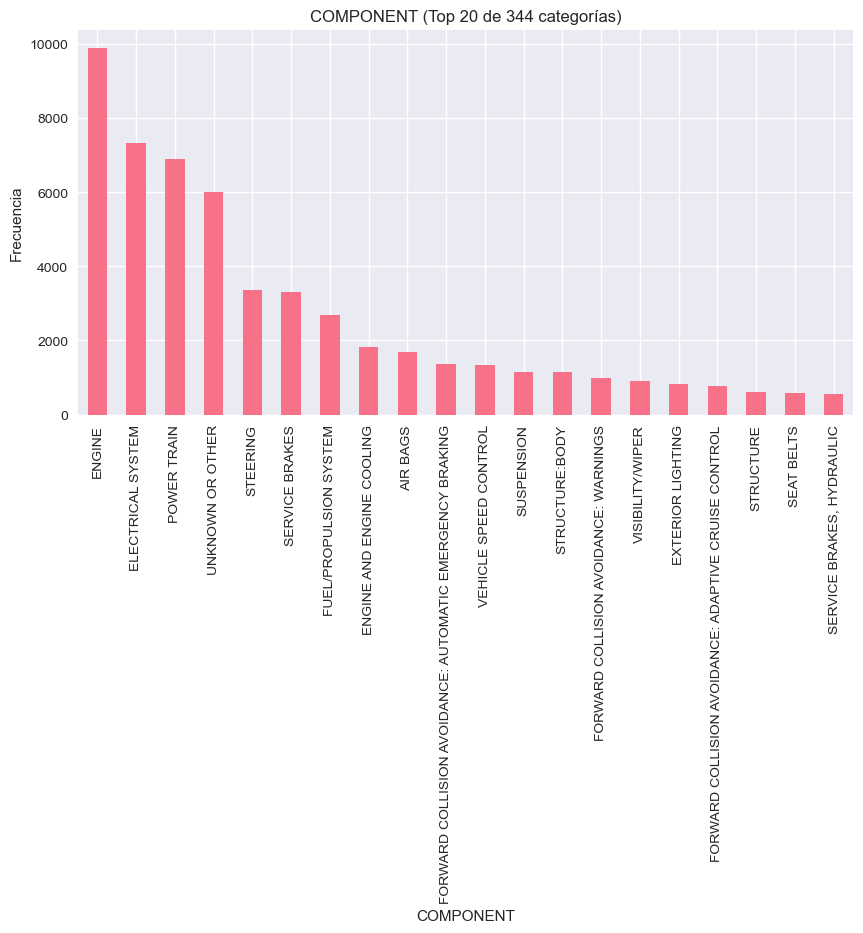

Guardado: results/figures/categorical/COMPONENT_distribution.png
[skip] CITY: alta cardinalidad (8161). Solo resumido.


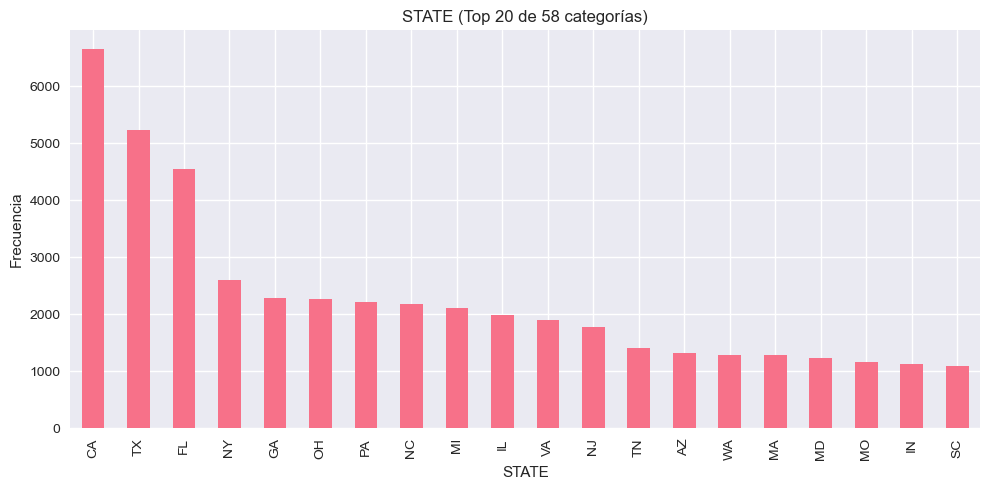

Guardado: results/figures/categorical/STATE_distribution.png
[skip] VIN: alta cardinalidad (29446). Solo resumido.
[skip] CMPLDESCR: alta cardinalidad (40816). Solo resumido.


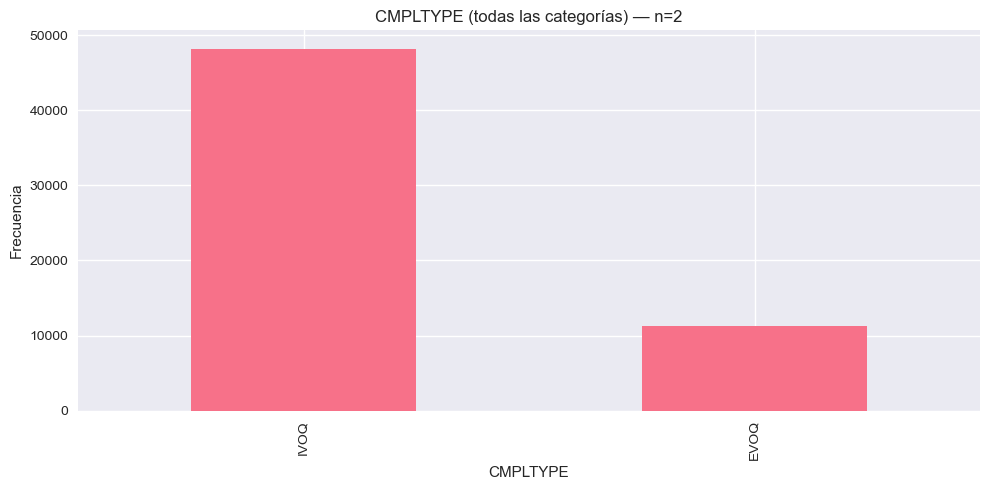

Guardado: results/figures/categorical/CMPLTYPE_distribution.png


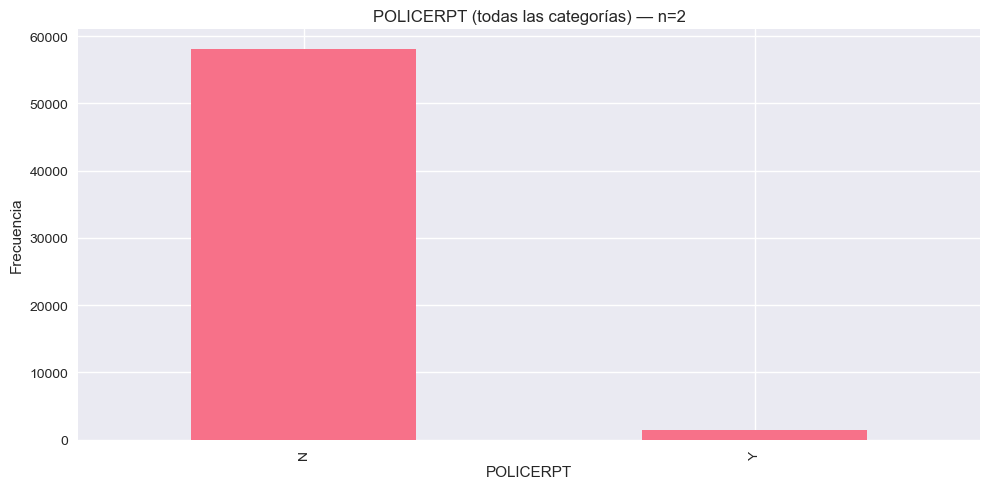

Guardado: results/figures/categorical/POLICERPT_distribution.png


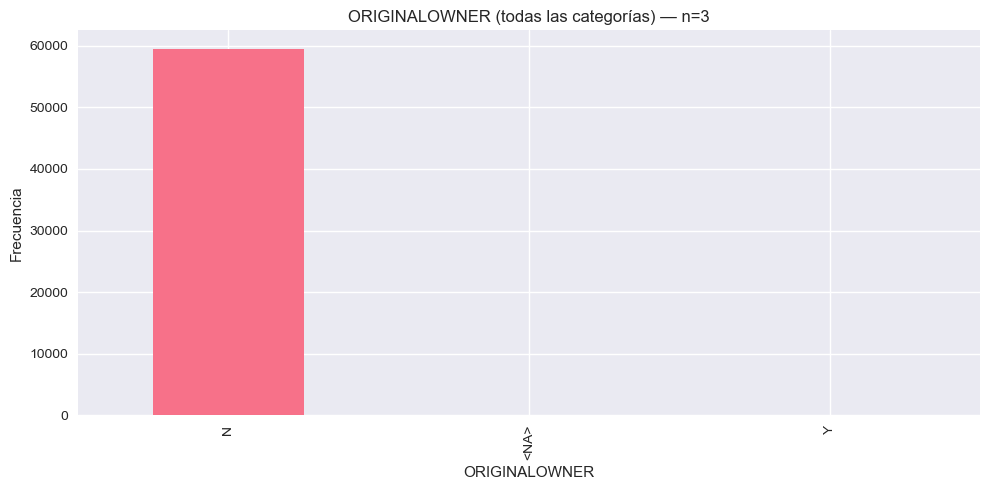

Guardado: results/figures/categorical/ORIGINALOWNER_distribution.png


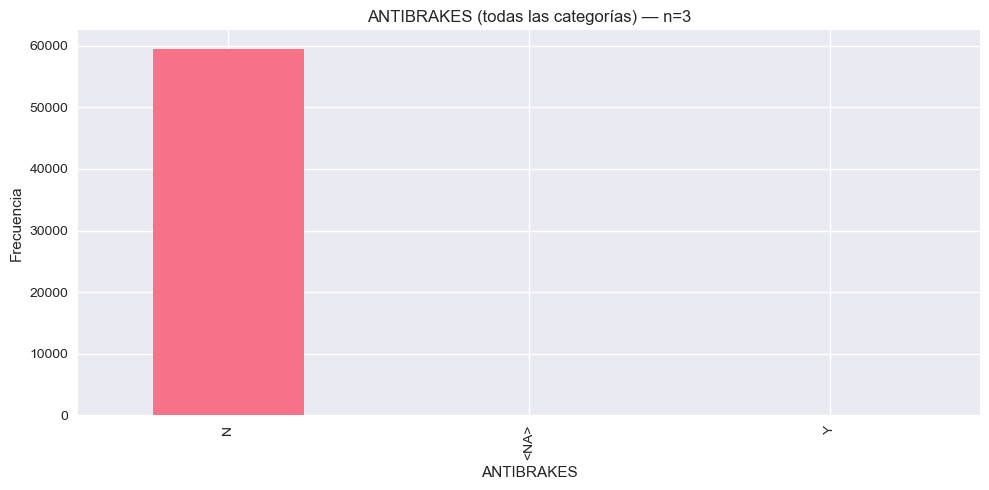

Guardado: results/figures/categorical/ANTIBRAKES_distribution.png


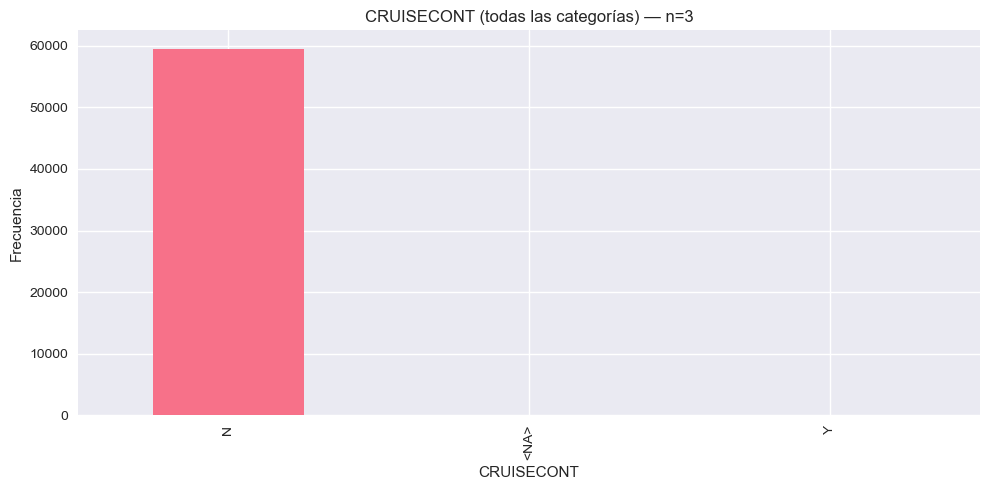

Guardado: results/figures/categorical/CRUISECONT_distribution.png
[skip] DEALERNAME: alta cardinalidad (3910). Solo resumido.
[skip] DEALERCITY: alta cardinalidad (1874). Solo resumido.


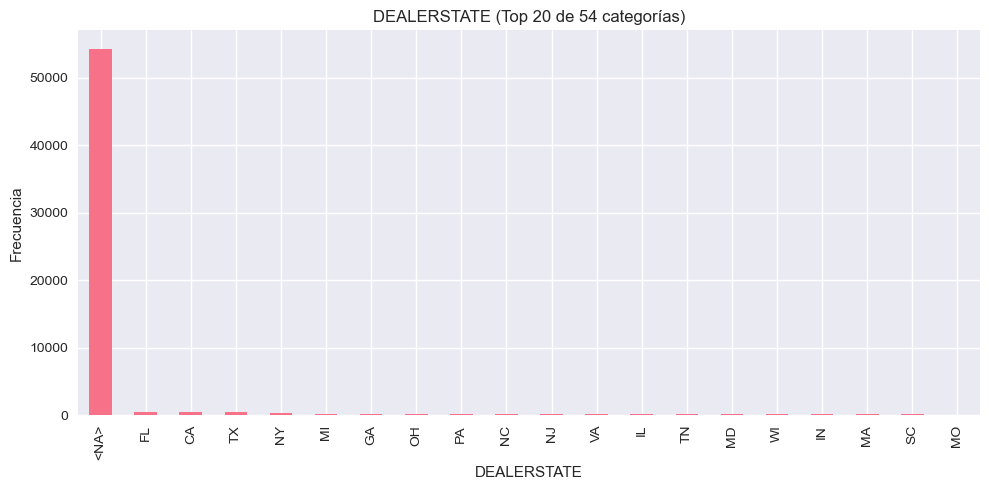

Guardado: results/figures/categorical/DEALERSTATE_distribution.png


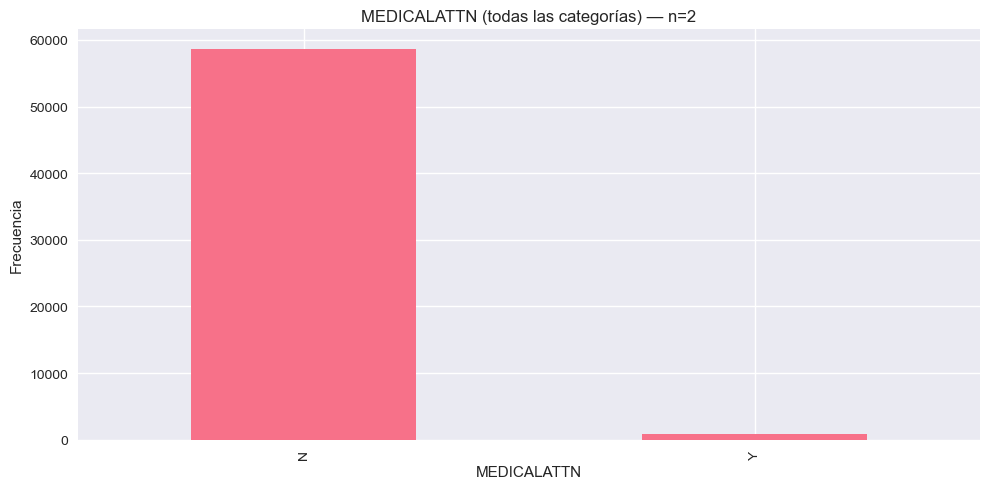

Guardado: results/figures/categorical/MEDICALATTN_distribution.png


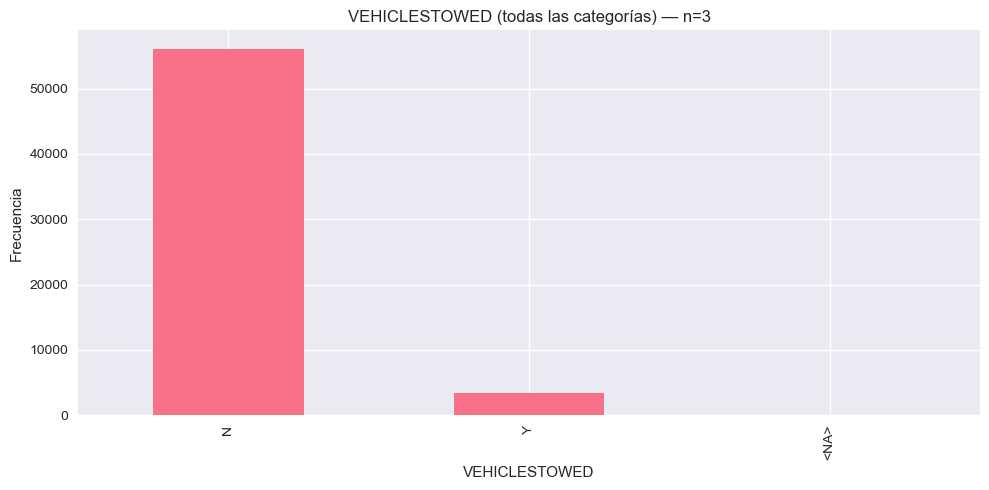

Guardado: results/figures/categorical/VEHICLESTOWED_distribution.png


In [14]:
def plot_categorical_distributions(df,
                                   max_levels_full=30,
                                   topN_medium=20,
                                   min_count_show=1,
                                   save_dir="results/figures/categorical"):
    import os
    os.makedirs(save_dir, exist_ok=True)
    cat_cols = get_categorical_columns(df)
    if not cat_cols:
        return

    for c in cat_cols:
        vc = df[c].astype("string").value_counts(dropna=False)
        nunique = vc.shape[0]

        # Filtra categorías con muy baja frecuencia si quieres
        vc = vc[vc >= min_count_show]

        plt.figure(figsize=(10, 5))
        if nunique <= max_levels_full:
            vc.plot(kind="bar")
            plt.title(f"{c} (todas las categorías) — n={nunique}")
        elif nunique <= 500:
            vc.head(topN_medium).plot(kind="bar")
            plt.title(f"{c} (Top {topN_medium} de {nunique} categorías)")
        else:
            plt.close()
            print(f"[skip] {c}: alta cardinalidad ({nunique}). Solo resumido.")
            continue

        plt.xlabel(c); plt.ylabel("Frecuencia")
        plt.tight_layout()
        out = f"{save_dir}/{c}_distribution.png"
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Guardado: {out}")

# Ejecución:
plot_categorical_distributions(df)

ANALISIS DE CORRELACION CON VARIABLES CATEGORICAS

=== Cardinalidad de las variables categóricas ===
CRASH: 2
FIRE: 2
CMPLTYPE: 2
POLICERPT: 2
ORIGINALOWNER: 2
ANTIBRAKES: 2
CRUISECONT: 2
MEDICALATTN: 2
VEHICLESTOWED: 2
DEALERSTATE: 53
STATE: 58
MFRNAME: 117
MAKE: 147
COMPONENT: 344
MODEL: 1106
DEALERCITY: 1873
DEALERNAME: 3909
CITY: 8160
VIN: 29445
CMPLDESCR: 40815

Variables categóricas seleccionadas (14):
['MFRNAME', 'MAKE', 'CRASH', 'FIRE', 'COMPONENT', 'STATE', 'CMPLTYPE', 'POLICERPT', 'ORIGINALOWNER', 'ANTIBRAKES', 'CRUISECONT', 'DEALERSTATE', 'MEDICALATTN', 'VEHICLESTOWED']

Codificando 14 variables categóricas...
  MFRNAME: 117 unique values
    ✓ Codificada MFRNAME (top 20 categories only)
  MAKE: 147 unique values
    ✓ Codificada MAKE (top 20 categories only)
  CRASH: 2 unique values
    ✓ Encoded CRASH
  FIRE: 2 unique values
    ✓ Encoded FIRE
  COMPONENT: 344 unique values
    ✓ Codificada COMPONENT (top 20 categories only)
  STATE: 58 unique values
    ✓ Encoded STATE
  

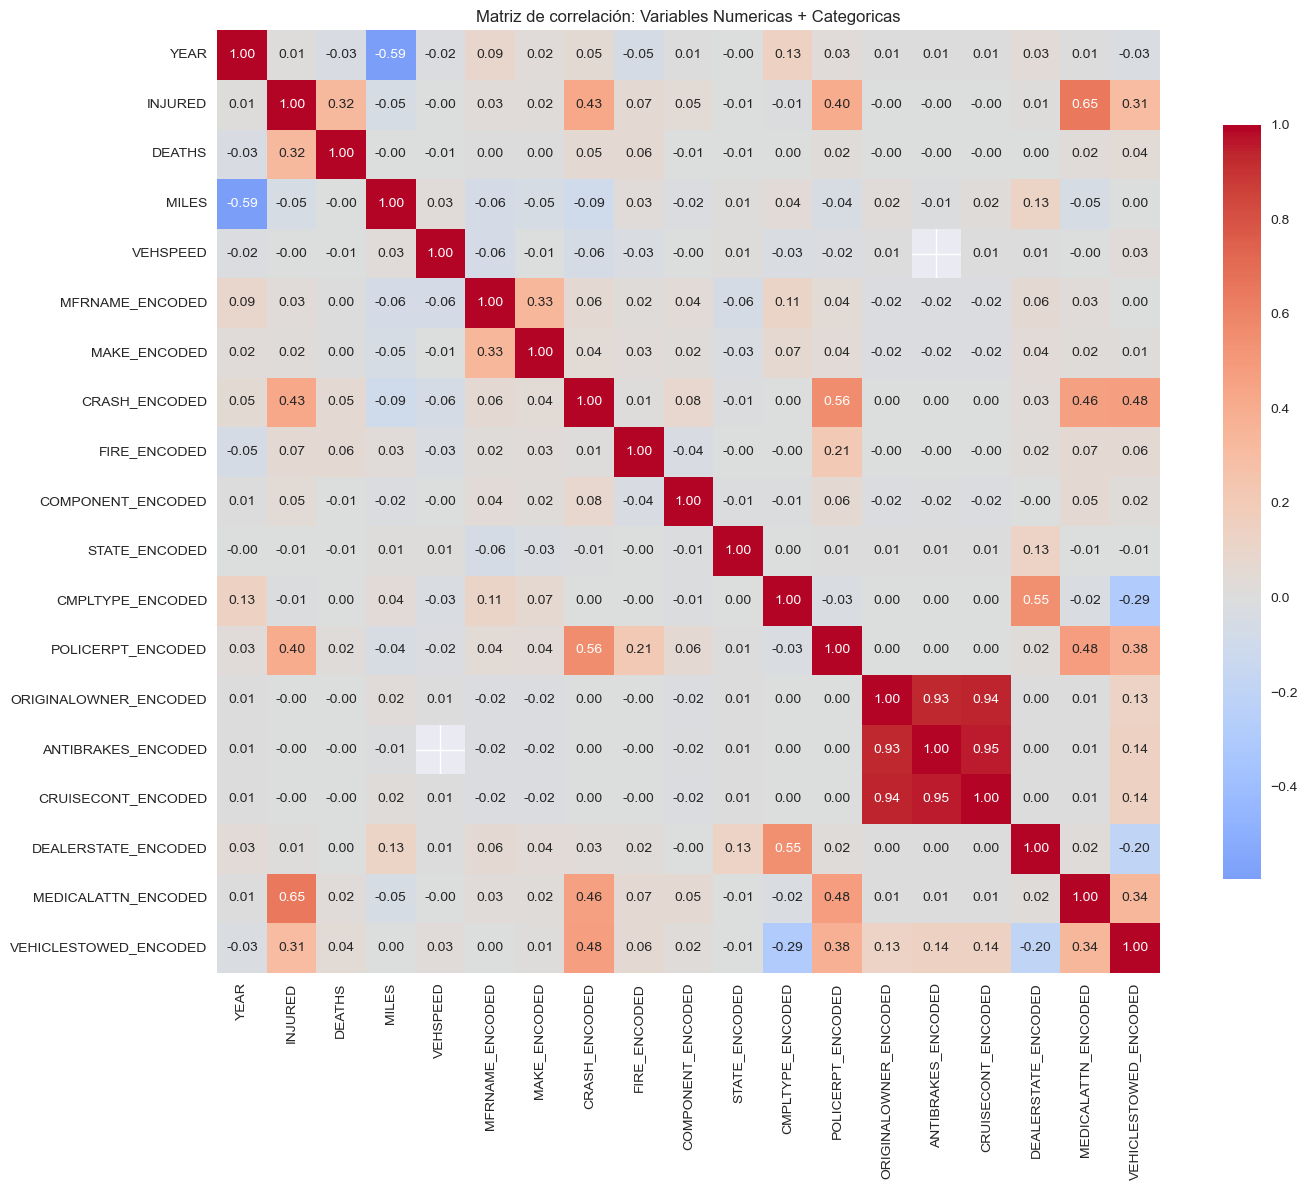


Correlación entre variables numericas and categoricas:
  INJURED vs CRASH: r = 0.426
  INJURED vs POLICERPT: r = 0.400
  INJURED vs MEDICALATTN: r = 0.651
  INJURED vs VEHICLESTOWED: r = 0.306

Correlaciones significativas (|r| > 0.5):
               Variable1            Variable2  Correlación
6     ANTIBRAKES_ENCODED   CRUISECONT_ENCODED     0.951056
5  ORIGINALOWNER_ENCODED   CRUISECONT_ENCODED     0.938111
4  ORIGINALOWNER_ENCODED   ANTIBRAKES_ENCODED     0.931571
1                INJURED  MEDICALATTN_ENCODED     0.651325
0                   YEAR                MILES    -0.594482
2          CRASH_ENCODED    POLICERPT_ENCODED     0.563065
3       CMPLTYPE_ENCODED  DEALERSTATE_ENCODED     0.547032


In [15]:
print("="*60)
print("ANALISIS DE CORRELACION CON VARIABLES CATEGORICAS")
print("="*60)

# Select key categorical variables for encoding
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Determinar cardinalidad por variable
cardinalities = {col: df[col].nunique() for col in cat_cols}
print("\n=== Cardinalidad de las variables categóricas ===")
for col, val in sorted(cardinalities.items(), key=lambda x: x[1]):
    print(f"{col}: {val}")

# Seleccionar variables con cardinalidad manejable
# - Binarias (2 valores) y bajas/medias (<= 500)
available_categorical = [col for col, n in cardinalities.items() if 2 <= n <= 500]

print(f"\nVariables categóricas seleccionadas ({len(available_categorical)}):")
print(available_categorical)

if not available_categorical:
    print("No se encontraron variables categóricas adecuadas para codificación.")
else:
    print(f"\nCodificando {len(available_categorical)} variables categóricas...")
    df_encoded = df.copy()
    
    # Create a copy for encoding
    df_encoded = df.copy()
    
    # Method 1: Label Encoding (simple numerical assignment)
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    
    encoded_cols = []
    for col in available_categorical:
        # Check unique values first
        unique_count = df_encoded[col].nunique()
        print(f"  {col}: {unique_count} unique values")
        
        # Try encoding with higher threshold or use top categories
        if unique_count <= 100:  # Increased threshold
            df_encoded[f"{col}_ENCODED"] = le.fit_transform(df_encoded[col].astype(str))
            encoded_cols.append(f"{col}_ENCODED")
            print(f"    ✓ Encoded {col}")
        elif unique_count <= 500:  # For medium cardinality, use top categories
            # Get top 20 categories and encode only those
            top_categories = df_encoded[col].value_counts().head(20).index
            df_encoded[f"{col}_ENCODED"] = df_encoded[col].apply(
                lambda x: top_categories.get_loc(x) if x in top_categories else -1
            )
            encoded_cols.append(f"{col}_ENCODED")
            print(f"    ✓ Codificada {col} (top 20 categories only)")
        else:
            print(f"    ✗ Skipped {col} (muchos valores únicos: {unique_count})")
    
    if not encoded_cols:
        print("No se detectaron variables categoricas para hacer one hot encoding con el umbral actual")
        
        # Alternative: Force encode top categories for each variable
        for col in available_categorical:
            top_categories = df_encoded[col].value_counts().head(10).index
            df_encoded[f"{col}_ENCODED"] = df_encoded[col].apply(
                lambda x: list(top_categories).index(x) if x in top_categories else -1
            )
            encoded_cols.append(f"{col}_ENCODED")
            print(f"  ✓ Force encoded {col} (top 10 categories only)")
    
    if not encoded_cols:
        print("No se encontrar variables para hacer un encoded.")
    else:
        # Combine numerical and encoded categorical columns
        all_corr_cols = numeric_cols.tolist() + encoded_cols
        
        # Calculate correlation matrix
        corr_data = df_encoded[all_corr_cols].select_dtypes(include=[np.number])
        correlation_matrix = corr_data.corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(15, 12))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Matriz de correlación: Variables Numericas + Categoricas')
        plt.tight_layout()
        plt.show()
        
        # Find correlations between numerical and categorical variables
        print("\nCorrelación entre variables numericas and categoricas:")
        for num_col in numeric_cols:
            for cat_col in encoded_cols:
                if num_col in correlation_matrix.columns and cat_col in correlation_matrix.columns:
                    corr_val = correlation_matrix.loc[num_col, cat_col]
                    if abs(corr_val) > 0.3:  # Lower threshold for categorical
                        print(f"  {num_col} vs {cat_col.replace('_ENCODED', '')}: r = {corr_val:.3f}")
        
        # Find high correlations among all variables
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.5:  # Lower threshold for mixed analysis
                    high_corr_pairs.append({
                        'Variable1': correlation_matrix.columns[i],
                        'Variable2': correlation_matrix.columns[j],
                        'Correlación': corr_val
                    })
        
        if high_corr_pairs:
            print(f"\nCorrelaciones significativas (|r| > 0.5):")
            high_corr_df = pd.DataFrame(high_corr_pairs)
            print(high_corr_df.sort_values('Correlación', key=abs, ascending=False))
        else:
            print("\nNo se encontró correlación significativa (|r| > 0.5)")


# Descripción de quejas

¿Cuáles son las características de las quejas? ¿Qué patrones podemos identificar en el texto?


## Limpieza del corpus

Se eliminarán stop words más otras palabras comunos que se han encontrado en nuestro cuerpo de texto, las cuales no aportan conocimiento y es información duplicada.

In [16]:
custom_stop = {"redacted","pursuant","freedom","information","act","xxx"}
stop_words = set(stopwords.words('english')) | custom_stop

lemmatizer = WordNetLemmatizer()

FOIA_REGEX = re.compile(
    r"\binformation\s+redacted\b.*?\bfreedom\s+of\s+information\s+act\b",
    flags=re.IGNORECASE
)

def strip_boilerplate(text: str) -> str:
    if not isinstance(text, str): return ""
    # 1) quita bloque FOIA completo (oraciones)
    txt = FOIA_REGEX.sub(" ", text)
    # 2) normaliza placeholders [XXX] o variantes
    txt = re.sub(r"\[+\s*xxx\s*\]+", " ", txt, flags=re.IGNORECASE)
    txt = re.sub(r"\bxxx\b", " ", txt, flags=re.IGNORECASE)
    # 3) espacios extra
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

df["CMPLDESCR_CLEAN1"] = df["CMPLDESCR"].fillna("").apply(strip_boilerplate)

TEXT_COL = next((c for c in ['CMPLDESCR_CLEAN1'] if c in df.columns), None)
assert TEXT_COL is not None, "No se encontró columna de texto."

def clean_text_keep_nums(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)   # letras, números y espacios
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words
             if (w not in stop_words) and (len(w) > 2 or w.isdigit())]
    return " ".join(words)

if TEXT_COL != 'CLEAN_TEXT':
    df['CLEAN_TEXT'] = df[TEXT_COL].fillna("").apply(clean_text_keep_nums).str.lower()
else:
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].fillna("")

TEXT CORPUS ANALYSIS - CMPLDESCR
Total de quejas: 59548
Quejas con descripciones: 59548
Descripciones faltantes: 0
Completitud de descripciones: 100.00%

Estadísticas de Longitud de Texto:
  Longitud media: 423.5 caracteres
  Mediana: 353.0 caracteres
  Longitud mínima: 0 caracteres
  Longitud máxima: 1693 caracteres
  Desviación estándar: 320.3 caracteres

Estadísticas de Conteo de Palabras:
  Promedio de palabras: 60.1
  Mediana de palabras: 50.0
  Mínimo de palabras: 0
  Máximo de palabras: 250


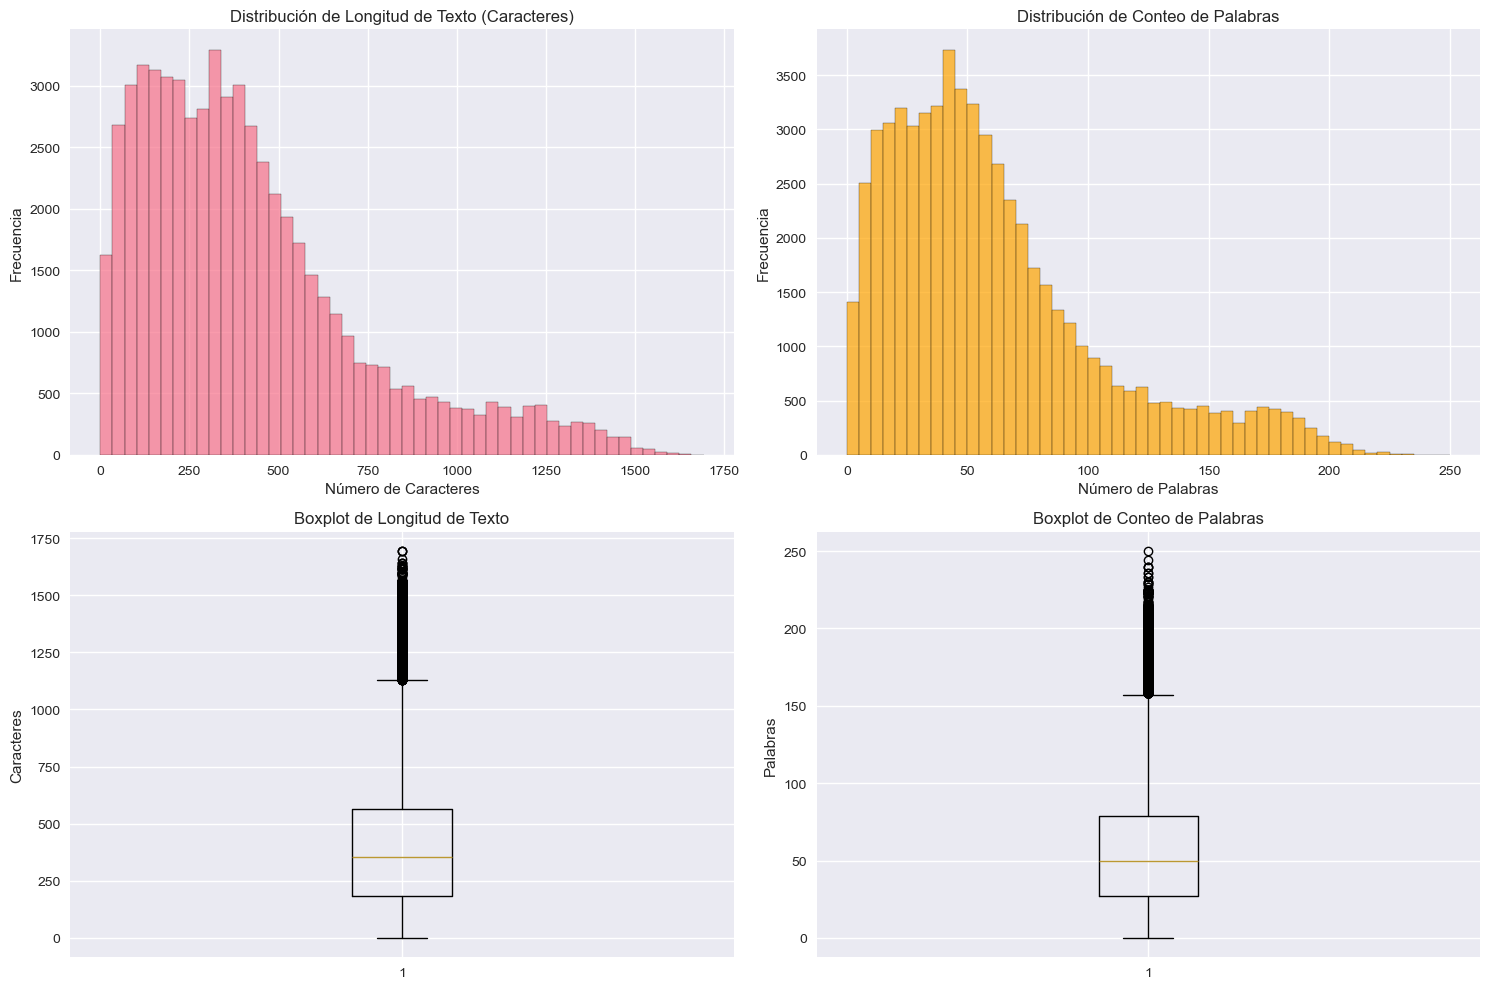

In [17]:
# Text Corpus Analysis - CMPLDESCR
print("="*60)
print("TEXT CORPUS ANALYSIS - CMPLDESCR")
print("="*60)

if 'CLEAN_TEXT' not in df.columns:
    print("Columna CLEAN_TEXT no encontrada en el dataset")
else:
    # Estadísticas básicas de texto
    text_col = df['CLEAN_TEXT']
    non_null_texts = text_col.dropna()
    
    print(f"Total de quejas: {len(df)}")
    print(f"Quejas con descripciones: {len(non_null_texts)}")
    print(f"Descripciones faltantes: {len(df) - len(non_null_texts)}")
    print(f"Completitud de descripciones: {len(non_null_texts)/len(df)*100:.2f}%")
    
    if len(non_null_texts) > 0:
        # Análisis de longitud de texto
        text_lengths = non_null_texts.str.len()
        print(f"\nEstadísticas de Longitud de Texto:")
        print(f"  Longitud media: {text_lengths.mean():.1f} caracteres")
        print(f"  Mediana: {text_lengths.median():.1f} caracteres")
        print(f"  Longitud mínima: {text_lengths.min()} caracteres")
        print(f"  Longitud máxima: {text_lengths.max()} caracteres")
        print(f"  Desviación estándar: {text_lengths.std():.1f} caracteres")
        
        # Análisis de conteo de palabras
        word_counts = non_null_texts.str.split().str.len()
        print(f"\nEstadísticas de Conteo de Palabras:")
        print(f"  Promedio de palabras: {word_counts.mean():.1f}")
        print(f"  Mediana de palabras: {word_counts.median():.1f}")
        print(f"  Mínimo de palabras: {word_counts.min()}")
        print(f"  Máximo de palabras: {word_counts.max()}")
        
        # Visualizar características del texto
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Distribución de longitud de caracteres
        axes[0,0].hist(text_lengths, bins=50, alpha=0.7, edgecolor='black')
        axes[0,0].set_title('Distribución de Longitud de Texto (Caracteres)')
        axes[0,0].set_xlabel('Número de Caracteres')
        axes[0,0].set_ylabel('Frecuencia')
        
        # Distribución de conteo de palabras
        axes[0,1].hist(word_counts, bins=50, alpha=0.7, edgecolor='black', color='orange')
        axes[0,1].set_title('Distribución de Conteo de Palabras')
        axes[0,1].set_xlabel('Número de Palabras')
        axes[0,1].set_ylabel('Frecuencia')
        
        # Diagrama de caja para longitud de texto
        axes[1,0].boxplot(text_lengths)
        axes[1,0].set_title('Boxplot de Longitud de Texto')
        axes[1,0].set_ylabel('Caracteres')
        
        # Diagrama de caja para conteo de palabras
        axes[1,1].boxplot(word_counts)
        axes[1,1].set_title('Boxplot de Conteo de Palabras')
        axes[1,1].set_ylabel('Palabras')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No hay descripciones de texto disponibles para análisis")




----------------------------------------
ANÁLISIS DE PALABRAS COMUNES
----------------------------------------
Top 20 palabras más comunes:
   1. vehicle         (98494 times)
   2. contact         (52796 times)
   3. car             (49513 times)
   4. failure         (42592 times)
   5. issue           (40064 times)
   6. engine          (37595 times)
   7. recall          (30237 times)
   8. light           (28511 times)
   9. driving         (27927 times)
  10. dealer          (26012 times)
  11. warning         (23416 times)
  12. time            (22044 times)
  13. stated          (21685 times)
  14. system          (19051 times)
  15. safety          (18835 times)
  16. manufacturer    (17290 times)
  17. brake           (17166 times)
  18. problem         (17134 times)
  19. dealership      (16472 times)
  20. repair          (15951 times)


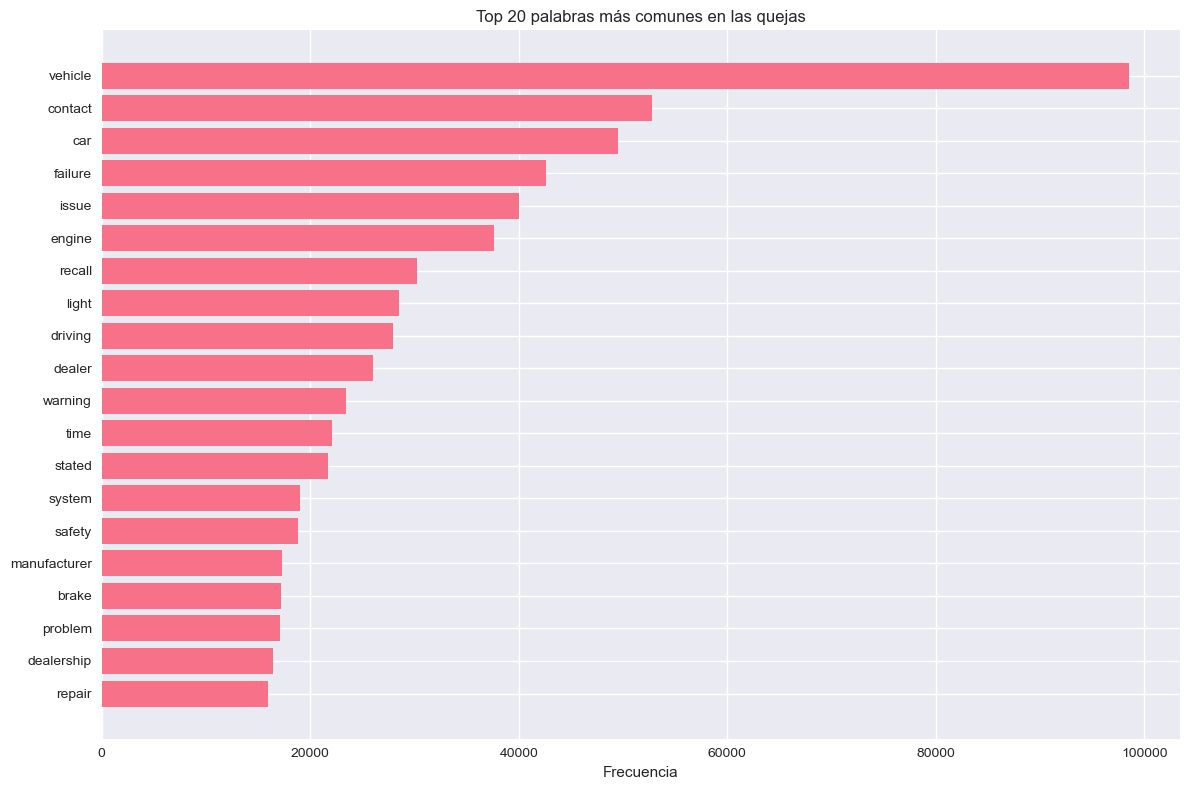

In [18]:
# Word Frequency Analysis
if 'CLEAN_TEXT' in df.columns and len(non_null_texts) > 0:
    print("\n" + "-"*40)
    print("ANÁLISIS DE PALABRAS COMUNES")
    print("-"*40)
    
    # Combine all texts
    all_text = ' '.join(non_null_texts.astype(str))
    
    # Basic word frequency (simple approach)
    words = all_text.lower().split()
       
    # Filter words
    filtered_words = [word for word in words if len(word) > 2 and word not in stop_words]
    
    # Count word frequencies
    from collections import Counter
    word_freq = Counter(filtered_words)
    
    # Get top 20 most common words
    top_words = word_freq.most_common(20)
    
    print("Top 20 palabras más comunes:")
    for i, (word, count) in enumerate(top_words, 1):
        print(f"  {i:2d}. {word:15s} ({count:4d} times)")
        
    # Visualize top words
    if top_words:
        words_list, counts_list = zip(*top_words)
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(words_list)), counts_list)
        plt.yticks(range(len(words_list)), words_list)
        plt.xlabel('Frecuencia')
        plt.title('Top 20 palabras más comunes en las quejas')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()



----------------------------------------
TEXT PATTERNS BY VARIABLES
----------------------------------------


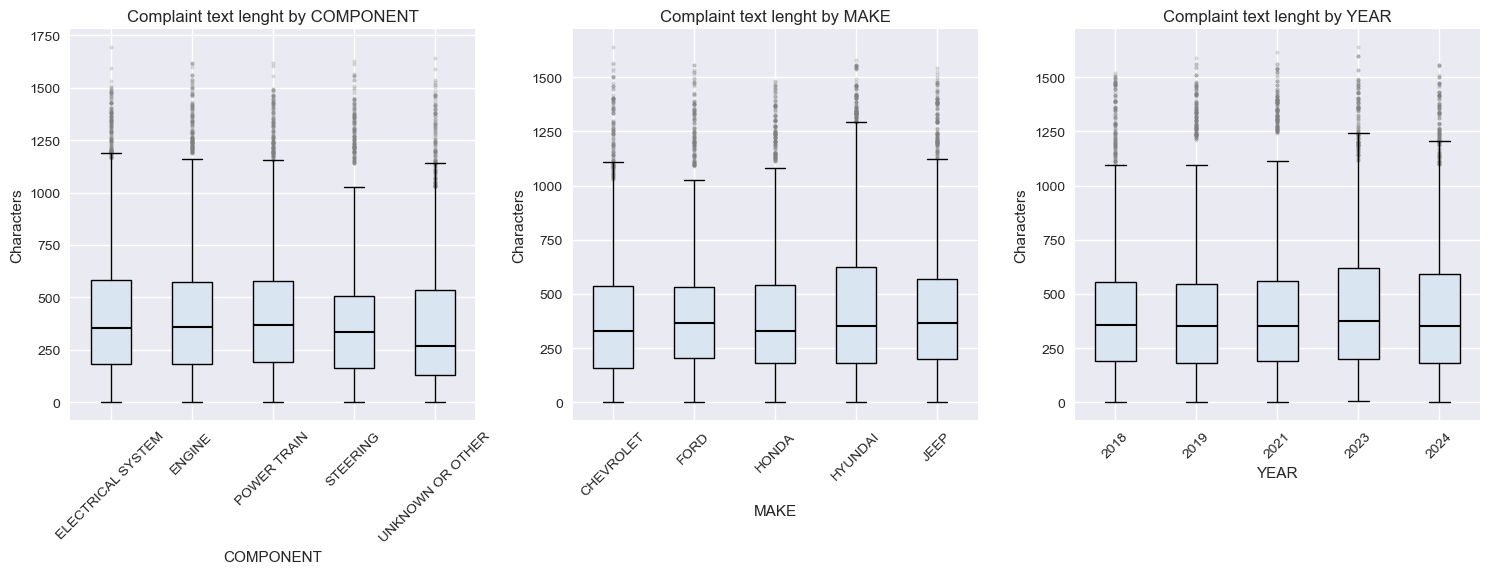


Ejemplos de quejas:

Complaint 1:
Length: 80 characters
Text: tailgate release multiple time day hear attempt light flash drained battery also

Complaint 2:
Length: 422 characters
Text: vehicle 45 000 mile right rear wheel bearing failed covered 5 year 60 000 mile warranty repaired today certified subaru dealer longer bad part inspection safety risk would anything occurs bad wheel bearing like wobble seizing overheating damage drivetrain component could hear wheel bearing noise 20 mph constant driving getting louder increased speed warning light present dash feel like 45 000 mile...

Complaint 3:
Length: 791 characters
Text: combustion engine sporadically fails start combustion engine longer started start stop function sporadically unavailable ready displayed yellow instrument cluster start stop function fails function properly dangerous road condition pulling intersection stop traffic proceeding stop light etc second time major incident occurred repaired december 2020 manufacturer wa

In [19]:
TEXT_COL = next((c for c in ['CLEAN_TEXT'] if c in df.columns), None)
if TEXT_COL is None:
    print("⚠️ No se encontró columna de texto (CMPLDESCR/CDESCR/DESCRIPTION).")
else:
    print("\n" + "-"*40)
    print("TEXT PATTERNS BY VARIABLES")
    print("-"*40)

    # Subconjunto con texto no nulo
    text_df = df[df[TEXT_COL].notna()].copy()

    # Asegurar string
    text_df[TEXT_COL] = text_df[TEXT_COL].astype(str)

    # Métricas de texto
    text_df['TEXT_LENGTH'] = text_df[TEXT_COL].str.len()
    text_df['WORD_COUNT']  = text_df[TEXT_COL].str.split().str.len()

    # Variables categóricas clave (si existen)
    key_vars = ['COMPONENT', 'MAKE', 'YEAR']
    available_vars = [v for v in key_vars if v in text_df.columns]

    if available_vars:
        fig, axes = plt.subplots(1, len(available_vars), figsize=(5*len(available_vars), 6))
        if len(available_vars) == 1:
            axes = [axes]

        for i, var in enumerate(available_vars):
            top = text_df[var].value_counts().head(5).index
            subset = text_df[text_df[var].isin(top)]

            subset.boxplot(
                column='TEXT_LENGTH', by=var, ax=axes[i],
                showfliers=False, patch_artist=True,
                boxprops=dict(facecolor='#d9e6f2'),
                medianprops=dict(color='black', linewidth=1.5),
                whiskerprops=dict(linewidth=1), capprops=dict(linewidth=1)
    )

            # Añadir “algunos” outliers por categoría (p. ej. 150 puntos máximo)
            for cat in top:
                y = subset.loc[subset[var] == cat, 'TEXT_LENGTH'].values
                q1, q3 = np.percentile(y, [25, 75])
                iqr = q3 - q1
                out = y[(y < q1 - 1.5*iqr) | (y > q3 + 1.5*iqr)]
                if len(out) > 0:
                    samp = np.random.choice(out, size=min(150, len(out)), replace=False)
                    x = np.full_like(samp, fill_value=list(top).index(cat)+1, dtype=float)
                    axes[i].scatter(x, samp, s=6, alpha=0.25, c='gray')  # puntos suaves

            axes[i].set_title(f'Complaint text lenght by {var}')
            axes[i].set_xlabel(var); axes[i].set_ylabel('Characters')
            axes[i].tick_params(axis='x', rotation=45)

        # Quita el suptitle automático de pandas
        plt.suptitle('')
        plt.tight_layout()
        plt.show()
    else:
        print("No hay variables categóricas disponibles entre MAKE/COMPONENT/STATE para graficar.")

    # --- Ejemplos de quejas ---
    print("\nEjemplos de quejas:")
    print("="*50)

    # Opción de textos aleatorios
    examples = text_df[TEXT_COL].sample(min(3, len(text_df)), random_state=42)

    for i, txt in enumerate(examples, 1):
        preview = txt[:400] + ("..." if len(txt) > 400 else "")
        print(f"\nComplaint {i}:")
        print(f"Length: {len(txt)} characters")
        print(f"Text: {preview}")

## Deduplicado de quejas para LDA

Para que nuestro análisis de tópicos no se vea afectado por los duplicados, crearemos otro dataframe manteniendo una sola descripción por queja y se consolidarán los componentes.



In [20]:
n_rows = len(df)

# Elegimos el ID de caso: prioriza ODINO
case_id_col = 'ODINO' if 'ODINO' in df.columns else ('CMPLID' if 'CMPLID' in df.columns else None)
assert case_id_col is not None, "No se encontró ODINO/CMPLID para agrupar casos."

# Selecciona para cada caso el texto más largo ya limpio (CLEAN_TEXT),
# y agrega la lista única de componentes.
df['_TEXT_LEN'] = df['CLEAN_TEXT'].fillna("").str.len()

# Índice de la fila con texto más largo por caso
idx_longest = df.groupby(case_id_col)['_TEXT_LEN'].idxmax()

# Arma el dataframe agregado
complaints_agg = (
    df.loc[idx_longest, [case_id_col, 'CLEAN_TEXT']]
      .merge(
          df.groupby(case_id_col)['COMPONENT']
            .apply(lambda s: sorted(set(s.dropna())))
            .rename('COMPONENTS')
            .reset_index(),
          on=case_id_col, how='left'
      )
)

# Renombra columnas
complaints_agg = complaints_agg.rename(columns={case_id_col: 'CASE_ID',
                                                'CLEAN_TEXT': 'DOC_TEXT'})

print(f"Reducción vs filas originales: {n_rows} -> {len(complaints_agg)}")

# Guarda el corpus limpio para LDA y NER
corpus_docs = complaints_agg['DOC_TEXT'].fillna("").str.lower().tolist()


# Diccionario CASE_ID -> componentes
id_to_components = dict(zip(complaints_agg['CASE_ID'], complaints_agg['COMPONENTS']))

# Limpieza de columna auxiliar
df.drop(columns=['_TEXT_LEN'], inplace=True, errors='ignore')

Reducción vs filas originales: 59548 -> 41247


## Nubes de palabras

Utilizamos nuestro corpus de quejas para poder detectar las palabras más utilizadas en los registros de nuestras variables clave. 

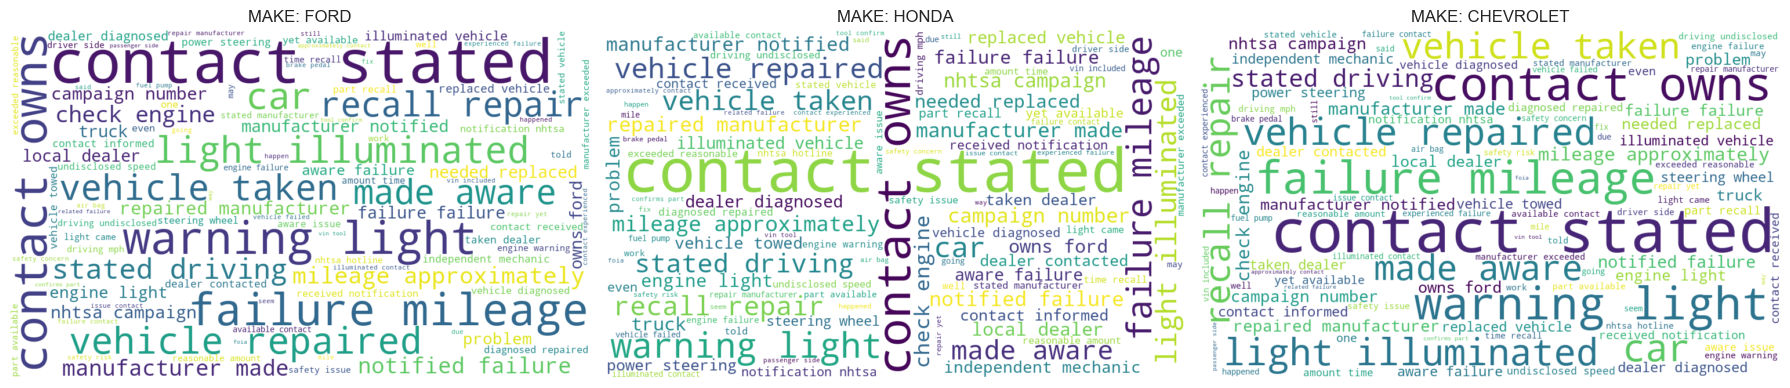

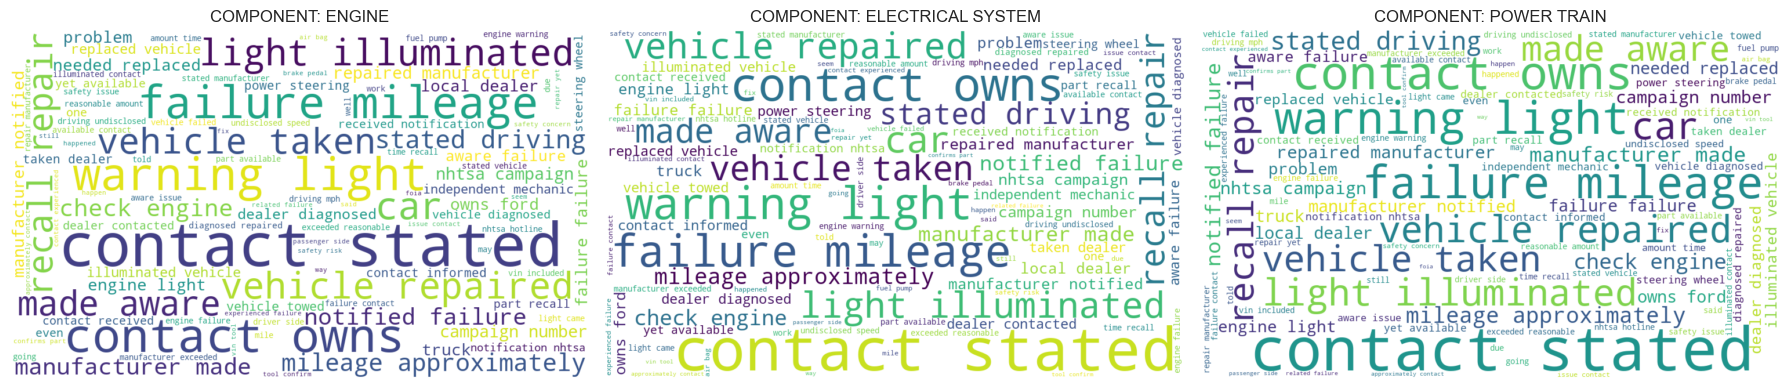

In [21]:
key_vars = ['MAKE', 'COMPONENT']
for var in key_vars:
    if var in df.columns:
        top_cats = df[var].value_counts().head(3).index
        fig, axes = plt.subplots(1, len(top_cats), figsize=(18, 6))
        for i, cat in enumerate(top_cats):
            text = " ".join(complaints_agg['DOC_TEXT'])
            wc = WordCloud(width=1000, height=600, background_color='white', max_words=100).generate(text)
            axes[i].imshow(wc, interpolation='bilinear')
            axes[i].axis('off')
            axes[i].set_title(f"{var}: {cat}")
        plt.tight_layout()
        plt.show()


## Bigramas

Detecta patrones comunes en combinaciones de 2 palabras, por ejemplo “check engine”, “air bag”, “power steering”.

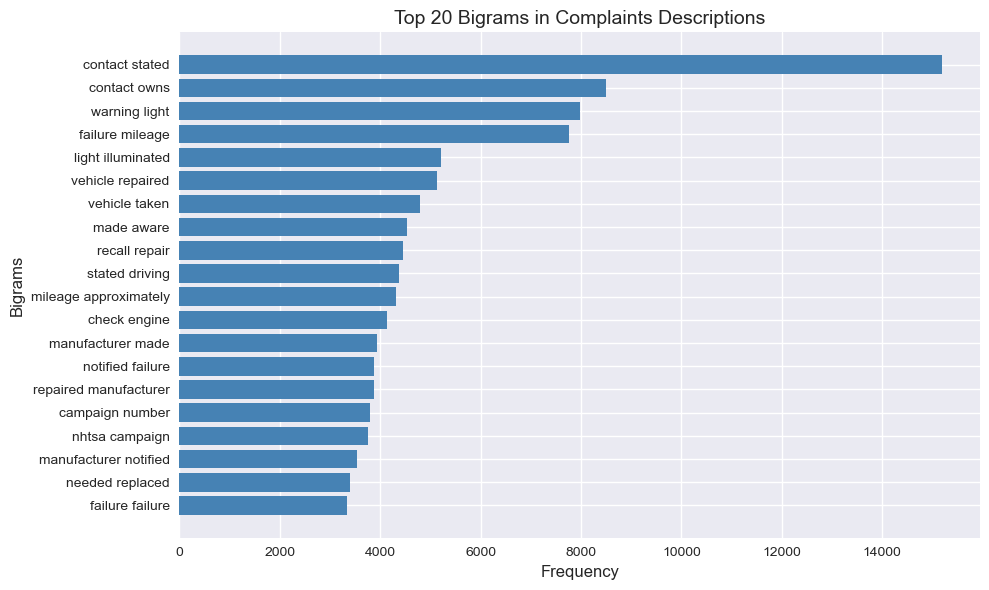

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus_docs, n=None, ngram_range=(2,2)):
    vec = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus_docs)
    bag_of_words = vec.transform(corpus_docs)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

bigrams = get_top_ngrams(complaints_agg['DOC_TEXT'], n=20, ngram_range=(2,2))

# Convertir los bigramas en dos listas: frases y frecuencias
bigrams_phrases = [phrase for phrase, freq in bigrams]
bigrams_freqs = [freq for phrase, freq in bigrams]

# Crear la figura
plt.figure(figsize=(10, 6))
plt.barh(bigrams_phrases[::-1], bigrams_freqs[::-1], color='steelblue')
plt.title("Top 20 Bigrams in Complaints Descriptions", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Bigrams", fontsize=12)
plt.tight_layout()
plt.show()


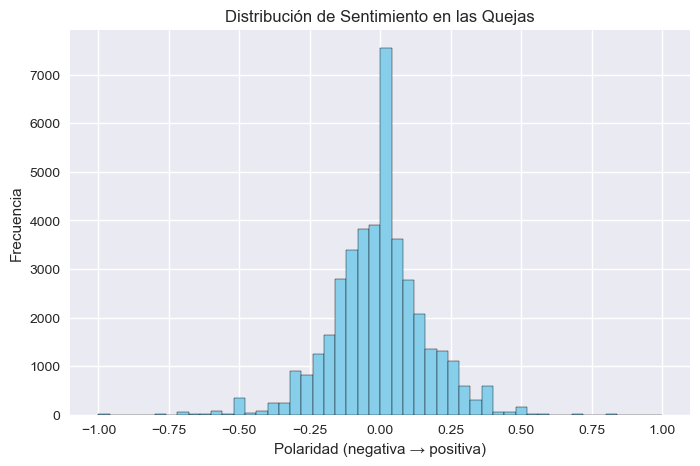

Promedio de sentimiento: -0.007
                                                DOC_TEXT  SENTIMENT
32503  mechanic discovered battery control module har...   0.100000
3836   open recall fuel pump vehicle honda refuse add...   0.300000
4765   coolant leaking system cylinder causing check ...   0.100000
4442   car shifted transmission neutral cruising inte...  -0.002778
39877  2015 nissan frontier air bag light came replac...   0.400000


In [23]:
from textblob import TextBlob

complaints_agg['SENTIMENT'] = complaints_agg['DOC_TEXT'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

plt.figure(figsize=(8,5))
complaints_agg['SENTIMENT'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title("Distribución de Sentimiento en las Quejas")
plt.xlabel("Polaridad (negativa → positiva)")
plt.ylabel("Frecuencia")
plt.show()

print(f"Promedio de sentimiento: {complaints_agg['SENTIMENT'].mean():.3f}")
print(complaints_agg[['DOC_TEXT','SENTIMENT']].sample(5))

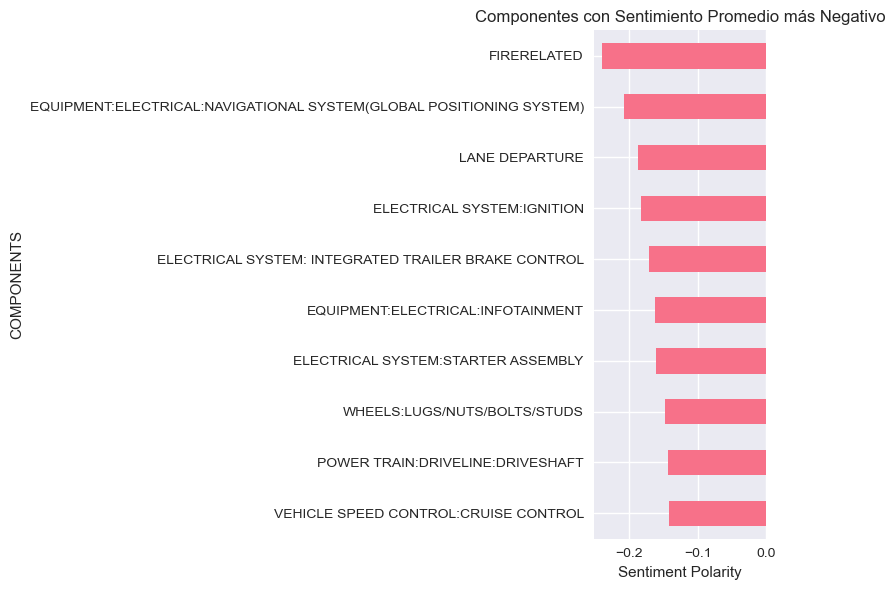

                                                    avg_sentiment   n
COMPONENTS                                                           
FIRERELATED                                             -0.240491  11
EQUIPMENT:ELECTRICAL:NAVIGATIONAL SYSTEM(GLOBAL...      -0.207714   5
LANE DEPARTURE                                          -0.188140   8
ELECTRICAL SYSTEM:IGNITION                              -0.182703   7
ELECTRICAL SYSTEM: INTEGRATED TRAILER BRAKE CON...      -0.171189  11
EQUIPMENT:ELECTRICAL:INFOTAINMENT                       -0.163149   8
ELECTRICAL SYSTEM:STARTER ASSEMBLY                      -0.161104   7
WHEELS:LUGS/NUTS/BOLTS/STUDS                            -0.148763  19
POWER TRAIN:DRIVELINE:DRIVESHAFT                        -0.143785   7
VEHICLE SPEED CONTROL:CRUISE CONTROL                    -0.143009  18


In [24]:
tmp = (complaints_agg
       .explode('COMPONENTS')
       .dropna(subset=['COMPONENTS']))

grouped = (tmp
           .groupby('COMPONENTS')
           .agg(avg_sentiment=('SENTIMENT','mean'),
                n=('SENTIMENT','size'))
           .query('n >= 5')  # mínimo 5 casos por componente (ajusta a gusto)
           .sort_values('avg_sentiment', ascending=True))

top10 = grouped.head(10)

ax = top10['avg_sentiment'].plot(kind='barh', figsize=(8,6))
ax.set_title("Componentes con Sentimiento Promedio más Negativo")
ax.set_xlabel("Sentiment Polarity")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(top10)

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Corpus final para LDA/NER (ya en minúsculas)

vectorizer = CountVectorizer(
    max_df=0.8,         # ignora términos demasiado comunes
    min_df=10,          # términos presentes al menos en 10 documentos
    ngram_range=(1,2),  # unigrams + bigrams
    stop_words='english'
)
X = vectorizer.fit_transform(corpus_docs)

n_topics = 10
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method='online',
    random_state=42,
    max_iter=10,
    evaluate_every=0
).fit(X)

# Mostrar top palabras por tema
feature_names = np.array(vectorizer.get_feature_names_out())

def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[-n_top_words:]
        print(f"\nTopic {idx+1}: ", list(feature_names[top_idx]))

print_topics(lda_model, feature_names, n_top_words=10)


Topic 1:  ['told', 'service', 'dealer', 'year', 'car', 'vehicle', 'problem', 'dealership', 'issue', 'recall']

Topic 2:  ['model', 'nhtsa', 'owner', 'concern', 'risk', 'recall', 'defect', 'issue', 'vehicle', 'safety']

Topic 3:  ['driving', 'braking', 'warning', 'collision', 'vehicle', 'driver', 'brake', 'camera', 'control', 'rear']

Topic 4:  ['day', 'start', 'started', 'light', 'fuel', 'door', 'driving', 'vehicle', 'battery', 'car']

Topic 5:  ['number', 'received', 'notification', 'campaign', 'manufacturer', 'available', 'recall repair', 'repair', 'recall', 'contact']

Topic 6:  ['light', 'power', 'turn', 'time', 'driving', 'stop', 'brake', 'steering', 'vehicle', 'car']

Topic 7:  ['cylinder', 'vehicle', 'engine light', 'coolant', 'check engine', 'failure', 'check', 'light', 'oil', 'engine']

Topic 8:  ['air', 'confirmed', 'available', 'prior', 'passenger', 'inspected', 'inspection', 'warning', 'failure', 'vehicle']

Topic 9:  ['headlight', 'recall', 'bmw', 'issue', 'failure', 'lig

In [26]:
import pyLDAvis
import inspect

# Datos base desde pipeline:
# - lda_model: instancia de sklearn.decomposition.LatentDirichletAllocation ya ajustada
# - X: matriz documento-término de CountVectorizer
# - vectorizer: CountVectorizer ajustado

def prepare_pyldavis_panel(lda_model, X, vectorizer):
    """
    Devuelve un panel de pyLDAvis, independiente de la versión instalada.
    Soporta:
      - API vieja: pyLDAvis.sklearn.prepare(lda_model, X, vectorizer)
      - API antigua de lda_model.prepare(lda_model, X, vectorizer)
      - API nueva (>=3.4): pyLDAvis.lda_model.prepare(topic_term_dists=..., doc_topic_dists=..., ...)
    """
    # 1) Intentar wrapper sklearn (presente en versiones viejas)
    try:
        import pyLDAvis.sklearn as pld_sklearn
        return pld_sklearn.prepare(lda_model, X, vectorizer, mds='tsne')
    except Exception:
        pass

    # 2) Intentar API de lda_model con firma antigua (lda_model, dtm, vectorizer)
    try:
        import pyLDAvis.lda_model as plda
        sig = inspect.signature(plda.prepare)
        params = list(sig.parameters.keys())
        if params[:3] == ['lda_model', 'dtm', 'vectorizer']:
            # Firma antigua
            return plda.prepare(lda_model, X, vectorizer, mds='tsne')
    except Exception:
        pass

    # 3) API nueva (>=3.4): requiere distribuciones explícitas
    import pyLDAvis.lda_model as plda

    topic_term = lda_model.components_.astype(float)
    topic_term = topic_term / topic_term.sum(axis=1, keepdims=True)

    doc_topic = lda_model.transform(X)
    doc_lengths = X.sum(axis=1).A1
    vocab = vectorizer.get_feature_names_out()
    term_frequency = X.sum(axis=0).A1

    return plda.prepare(
        topic_term_dists=topic_term,
        doc_topic_dists=doc_topic,
        doc_lengths=doc_lengths,
        vocab=vocab,
        term_frequency=term_frequency,
        sort_topics=False
    )

# Usar el panel
pyLDAvis.enable_notebook()
panel = prepare_pyldavis_panel(lda_model, X, vectorizer)
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      40.382977 -38.832947       1        1  21.404708
0      -2.233037  38.007759       2        1  15.076965
5     -24.588015   9.484824       3        1  12.957318
1      -2.724628 -15.020015       4        1  11.235277
3      54.018848  -1.606877       5        1  10.063790
6      26.178154 -12.681928       6        1   8.271480
2     -29.220453 -27.633160       7        1   6.621833
7       9.749516  11.078405       8        1   5.709838
4       6.035209 -44.880177       9        1   4.869506
8      35.584206  27.319283      10        1   3.789287, topic_info=               Term          Freq         Total Category  logprob  loglift
6234        contact  42585.000000  42585.000000  Default  30.0000  30.0000
9478         engine  26020.000000  26020.000000  Default  29.0000  29.0000
4287            car  29013.000000  29013.000000  Default  28.0000  28.0000
20462        recall  21195.000000  21195.000000  Default  27.0000  27.0000
26421  transmission   8294.000000   8294.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
21393      replaced    573.389566   8371.209671  Topic10  -5.3331   0.5920
22797        screen    460.883344   2179.478457  Topic10  -5.5516   1.7193
652            2019    441.210509   2304.609555  Topic10  -5.5952   1.6198
24014         speed    456.802532   7557.149224  Topic10  -5.5605   0.4670
19234         power    417.040177   8463.565805  Topic10  -5.6515   0.2626

[650 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
0          2  0.997020    00
0          5  0.001629    00
6          1  0.557894   000
6          2  0.195879   000
6          6  0.183561   000
...      ...       ...   ...
29369      5  0.003058  year
29369      6  0.002854  year
29369      7  0.000204  year
29369     10  0.000612  year
29451      8  0.998200   yes

[1306 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 6, 2, 4, 7, 3, 8, 5, 9])

In [27]:
pyLDAvis.save_html(panel, "lda_topics.html")
print("LDA panel guardado")

LDA panel guardado


TOPIC_ID
1     7673
2     3818
3     2674
4     4387
5     1687
6     7696
7     3146
8     1610
9     1037
10    7519
Name: count, dtype: int64

,TOPIC_ID,COMPONENTS,n
456,7,ENGINE,2532
21,1,ENGINE,1921
429,6,STEERING,1684
421,6,POWER TRAIN,1640
283,4,ELECTRICAL SYSTEM,1551
398,6,ELECTRICAL SYSTEM,1548
90,1,UNKNOWN OR OTHER,1542
403,6,ENGINE,1531
56,1,POWER TRAIN,1499
426,6,SERVICE BRAKES,1391


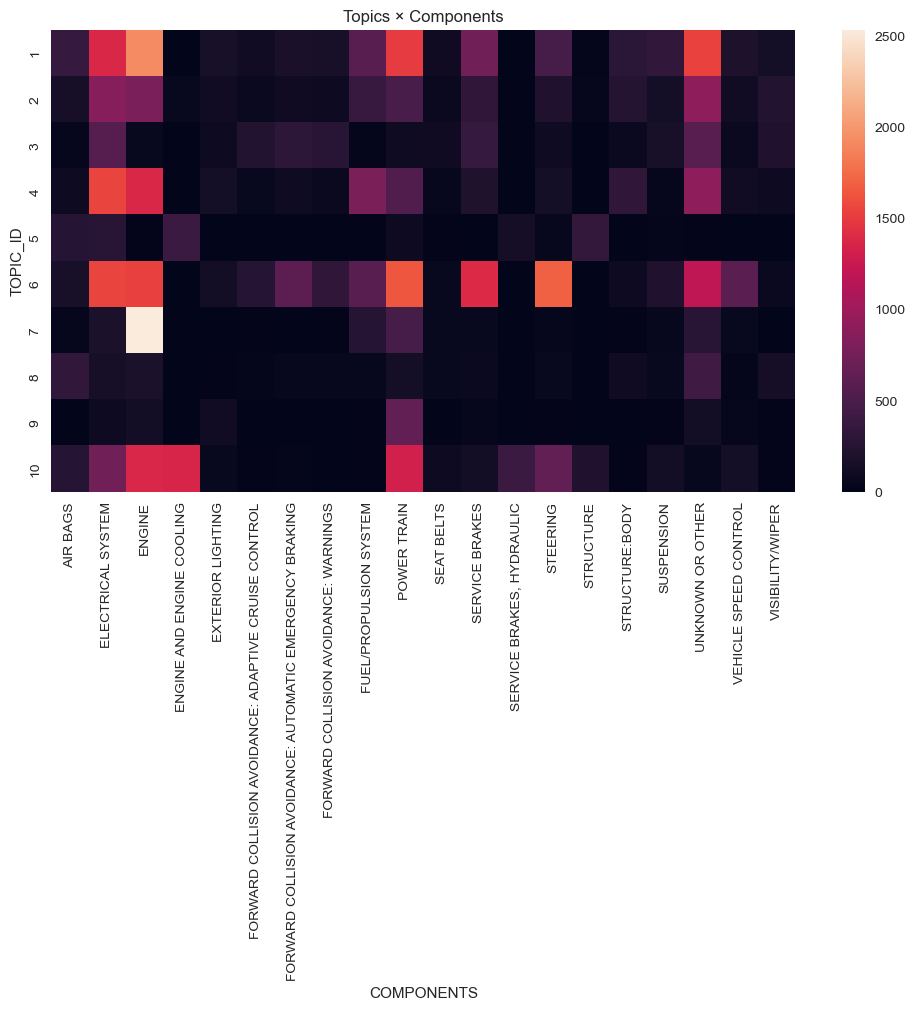

In [28]:
doc_topic = lda_model.transform(X)
complaints_agg['TOPIC_ID'] = doc_topic.argmax(axis=1) + 1
complaints_agg['TOPIC_SCORE'] = doc_topic.max(axis=1)

# Distribución por tema
topic_counts = complaints_agg['TOPIC_ID'].value_counts().sort_index()
display(topic_counts)

# Cruce TEMA × COMPONENTE (explotando la lista)
cross_comp = (
    complaints_agg
      .explode('COMPONENTS')
      .dropna(subset=['COMPONENTS'])
      .groupby(['TOPIC_ID','COMPONENTS'])
      .size()
      .reset_index(name='n')
      .sort_values('n', ascending=False)
)

display(cross_comp.head(20))

# Heatmap (temas vs top componentes):

top_comps = cross_comp.groupby('COMPONENTS')['n'].sum().sort_values(ascending=False).head(20).index
heat = (cross_comp[cross_comp['COMPONENTS'].isin(top_comps)]
        .pivot(index='TOPIC_ID', columns='COMPONENTS', values='n')
        .fillna(0))
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(12,6)); sns.heatmap(heat, annot=False); plt.title('Topics × Components'); plt.show()

In [29]:
if 'MAKE' in complaints_agg.columns:
    cross_make = (complaints_agg.groupby(['TOPIC_ID','MAKE'])
                  .size().reset_index(name='n')
                  .sort_values('n', ascending=False))
    display(cross_make.head(20))

if 'MODEL' in complaints_agg.columns:
    cross_year = (complaints_agg.groupby(['TOPIC_ID','MODEL'])
                  .size().reset_index(name='n')
                  .sort_values('n', ascending=False))
    display(cross_year.head(20))

## Nombramiento de entidades

NER (Reconocimiento de Entidades Nombradas) te permite extraer automáticamente entidades concretas de los textos, esto servirá más adelante para alimentar los grafos de conocimiento.

### Reglas de dominio con EntityRuler (pisan a NER)


Creamos un label custom (por ejemplo COMPONENT_MSG) o usamos uno propio COMPONENT. Añadimos patrones para mensajes conocidos y componentes del dat

In [30]:
import spacy
from spacy.pipeline import EntityRuler

nlp = spacy.load("en_core_web_sm")

ruler = nlp.add_pipe("entity_ruler", before="ner")  # importante: antes del NER
patterns = []

# 1) Mensajes comunes de tablero
msgs = [
    "check brake system", "collision assist unavailable", "engine light",
    "service brake system", "check engine", "service transmission",
    "power steering assist fault", "brake is not on"
]
patterns += [{"label": "COMPONENT_MSG", "pattern": m} for m in msgs]

# 2) Componentes conocidos (puedes cargar desde df['COMPONENT'].unique())
components_vocab = {
    "ENGINE","TRANSMISSION","BRAKE","BRAKES","AIR BAG","AIRBAG","POWER STEERING",
    "FUEL INJECTOR","COOLING SYSTEM","ELECTRICAL SYSTEM","BATTERY","WIRING",
    "SEAT BELT","SEATBELT","TIRE","TIRES","AXLE","FRAME","SUNROOF","HEADLIGHT"
}
patterns += [{"label": "COMPONENT", "pattern": c.lower()} for c in components_vocab]

ruler.add_patterns(patterns)

In [31]:

# Para rendimiento, procesa una muestra (ajusta n_docs según tu RAM/tiempo)
n_docs = min(5000, len(df))
sample_texts = complaints_agg["DOC_TEXT"].dropna().astype(str).head(n_docs).tolist()

ents = []
for i, doc in enumerate(nlp.pipe(sample_texts, batch_size=64, disable=["parser","tagger"])):
    for e in doc.ents:
        ents.append((i, e.text, e.label_))

ner_df = pd.DataFrame(ents, columns=['doc_idx','entity','label'])
display(ner_df.head())

# Top entidades por tipo
top_by_label = (ner_df.groupby(['label','entity']).size()
                       .reset_index(name='n')
                       .sort_values(['label','n'], ascending=[True, False]))
display(top_by_label.groupby('label').head(10))


,doc_idx,entity,label
0,0,engine,COMPONENT
1,0,power steering,COMPONENT
2,1,engine,COMPONENT
3,1,engine,COMPONENT
4,1,engine,COMPONENT


,label,entity,n
332,CARDINAL,2,275
1313,CARDINAL,one,274
808,CARDINAL,5,269
657,CARDINAL,3,188
1340,CARDINAL,two,184
...,...,...,...
4845,TIME,30 minute,16
4806,TIME,15 minute,12
4891,TIME,afternoon,12
4820,TIME,20 minute,10


In [32]:
from spacy import displacy

sample = complaints_agg["DOC_TEXT"].dropna().sample(3, random_state=42).tolist()
docs = list(nlp.pipe(sample))
for d in docs:
    displacy.render(d, style="ent", jupyter=True, options={"colors": {"COMPONENT":"#8dd3c7","COMPONENT_MSG":"#ffffb3"}})

c:\Users\moral\anaconda3\Lib\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


c:\Users\moral\anaconda3\Lib\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


c:\Users\moral\anaconda3\Lib\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [33]:
ents = []
for doc in nlp.pipe(complaints_agg["DOC_TEXT"].dropna().astype(str).head(5000), batch_size=64):
    ents += [(e.text, e.label_) for e in doc.ents]

ner_df = pd.DataFrame(ents, columns=["entity","label"])
display(ner_df["label"].value_counts().head(20))
display(ner_df.groupby("label").head(10))

label
COMPONENT        6536
CARDINAL         5608
DATE             4217
ORG              2448
QUANTITY         1947
ORDINAL           727
PERSON            610
TIME              579
COMPONENT_MSG     548
PRODUCT           280
GPE               258
MONEY              47
NORP               41
FAC                36
LOC                24
LAW                 9
PERCENT             7
EVENT               3
WORK_OF_ART         1
Name: count, dtype: int64

,entity,label
0,engine,COMPONENT
1,power steering,COMPONENT
2,engine,COMPONENT
3,engine,COMPONENT
4,engine,COMPONENT
...,...,...
15100,cyl 3,LAW
19735,elantra,LAW
20688,1 gdi,PERCENT
22326,chapter 7bankrupty,LAW


In [34]:
def has_component(term, text):
    return term.lower() in text.lower()

probe = df[["CMPLDESCR","COMPONENT"]].dropna().sample(1000, random_state=42).copy()
probe["detected_component"] = probe["CMPLDESCR"].apply(
    lambda t: any(k in t.lower() for k in ["brake","engine","transmission","air bag","airbag","steering"])
)
probe["declared_brake"] = probe["COMPONENT"].str.contains("BRAKE", case=False, na=False)

# Matriz 2x2 (sencilla) para BRAKE vs. detección textual
pd.crosstab(probe["declared_brake"], probe["detected_component"], rownames=["COMPONENT=BRAKE"], colnames=["NER/lexicon detected"])

NER/lexicon detected,False,True
COMPONENT=BRAKE,,
False,430,486
True,19,65
